# SWB Regression Pipeline - HFA RPE vs Profit Encoding 
Created: 09/30/2024 \
Updated: 10/01/2024 \
*ran with 1 sec regression dfs from 09/25/2024*

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm
import patsy
from statsmodels.api import OLS
from scipy import stats
from tqdm import tqdm
# from sklearn.linear_model import RANSACRegressor
# from sklearn.metrics import r2_score, mean_squared_error



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/'
anat_dir   = f'{base_dir}recon_labels/'
neural_dir = f'{base_dir}data/'
save_dir   = f'{base_dir}results/bandpow_encoding_models/'
fig_dir    = f'{base_dir}figs/bandpow_regressions/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)



10012024


In [4]:
import sys
sys.path.append(f'{base_dir}LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


# Load beta power data 

In [6]:
epoch_len = '1sec'

In [7]:
band = 'theta' 
theta_df = pd.read_csv(f'{save_dir}regression_dfs/{band}_master_df_{epoch_len}.csv')
theta_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [8]:
roi_reref_labels_master_df = pd.read_csv(
    glob(f'{base_dir}results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [9]:
roi_reref_labels_master_df.roi.value_counts()

roi
dmpfc            225
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
temporal         105
vlpfc             82
ains              71
pins              60
thalamus          58
temporal pole     31
mcc               28
phg               25
motor             25
parietal          24
vmpfc             23
caudate            8
pcc                1
Name: count, dtype: int64

In [10]:
# keep_rois = roi_reref_labels_master_df.roi.value_counts().index[
#     roi_reref_labels_master_df.roi.value_counts().values>=50].tolist()

keep_rois = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins','acc','amy','hpc']     
keep_rois


['dlpfc', 'vlpfc', 'dmpfc', 'ofc', 'ains', 'pins', 'acc', 'amy', 'hpc']

In [11]:
# ####### NEW DATA FRAME 
theta_reg_df = theta_df.copy()
theta_reg_df = theta_reg_df[theta_reg_df.roi.isin(keep_rois)]

# RPE ONLY MODELS

In [12]:
elec_col    = 'unique_reref_ch'
main_var    = 'rpe'
# reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+rpe'

n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(theta_reg_df,reg_formula,elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2953.58it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3003.07it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3047.28it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2976.57it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2937.61it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1886.95it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2920.98it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 1857.34it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2928.73it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2956.07it/s]


In [13]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'rpe']

In [14]:
results = single_elec_permutation_results(results_dict,theta_reg_df,save_vars)
results

unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.177645   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.033192   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.101572   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.079442   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.153425   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.146121   
1184  DA039_rpins2-rpins3   DA039   pins   22                    -0.051101   
1185  DA039_rpins3-rpins4   DA039   pins   22                    -0.010621   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.112806   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.133010   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.120075                  -0.013200   
1                                   0.089612                  -0.009826   
2                                   0.024498                  -0.129171   
3                                   0.025663                   0.133454   
4                                   0.039353                   0.040516   
...                                      ...                        ...   
1183                               -0.006766                   0.043373   
1184                                0.169133                   0.218364   
1185                                0.022906                  -0.035404   
1186                                0.114847                  -0.041343   
1187                                0.125267                  -0.030598   

      Original_Estimate_rpe  Permuted_Mean_Intercept  \
0                  0.046068                 0.092067   
1                  0.102186                 0.099432   
2                 -0.091329                 0.119400   
3                 -0.104359                 0.099576   
4                 -0.030427                 0.180807   
...                     ...                      ...   
1183              -0.007157                 0.148896   
1184               0.007048                 0.025580   
1185              -0.049195                -0.001583   
1186               0.012444                -0.070644   
1187              -0.086549                -0.083668   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TrialEV  \
0                               0.003197  ...              0.075814   
1                              -0.005870  ...              0.093600   
2                              -0.001848  ...              0.076422   
3                              -0.002738  ...              0.078411   
4                               0.000084  ...              0.085621   
...                                  ...  ...                   ...   
1183                           -0.007141  ...              0.099374   
1184                            0.004808  ...              0.082053   
1185                           -0.003148  ...              0.079184   
1186                            0.003044  ...              0.076334   
1187                           -0.000746  ...              0.080186   

      Permuted_Std_rpe  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0             0.071470           1.485393                     -1.486496   
1             0.086067          -0.973684                      0.975263   
2             0.072131          -0.319400                      0.327934   
3             0.076914          -0.305801                      0.299664   
4             0.079879          -0.431789                      0.430261   
...                ...                ...                           ...   
1183          0.083527          -0.064196                      0.003704   
1184          0.071332          -2.173998      

### Save results as pickle file

In [15]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_regression_results_rpemodel_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

# RPE Results

In [16]:
sig_data = results[results.P_Value_rpe < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
21    MS002_laims13-laims14   MS002  dmpfc   14                     0.194057   
50      MS002_racas3-racas4   MS002    acc   14                     0.120778   
57      MS002_ragit3-ragit4   MS002    amy   14                     0.028975   
103     MS003_racas5-racas6   MS003    acc    8                     0.103639   
104     MS003_racas6-racas7   MS003  dmpfc    8                     0.026086   
...                     ...     ...    ...  ...                          ...   
1159    DA039_rains3-rains4   DA039   ains   22                    -0.116158   
1160    DA039_rains4-rains5   DA039   ains   22                    -0.056916   
1172        DA039_rof1-rof2   DA039    ofc   22                    -0.121432   
1176        DA039_rof5-rof6   DA039    ofc   22                    -0.040370   
1177        DA039_rof6-rof7   DA039  dlpfc   22                    -0.061321   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
21                                 -0.034317                   0.020611   
50                                 -0.023143                  -0.002153   
57                                 -0.071180                   0.018594   
103                                 0.068039                   0.074887   
104                                 0.146861                  -0.098990   
...                                      ...                        ...   
1159                                0.177963                   0.010174   
1160                                0.044997                   0.080147   
1172                                0.116846                  -0.038491   
1176                                0.000990                  -0.012472   
1177                                0.136752                   0.115011   

      Original_Estimate_rpe  Permuted_Mean_Intercept  \
21                 0.253476                 0.170300   
50                 0.162328                 0.104831   
57                -0.111673                -0.019463   
103                0.195901                 0.127750   
104               -0.191533                 0.077111   
...                     ...                      ...   
1159              -0.202306                -0.043355   
1160              -0.180313                -0.034640   
1172              -0.156345                -0.076078   
1176              -0.186631                -0.039278   
1177              -0.140364                 0.000837   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TrialEV  \
21                              0.000078  ...              0.107679   
50                             -0.000134  ...              0.080942   
57                             -0.001303  ...              0.043280   
103                            -0.000730  ...              0.076714   
104                            -0.002252  ...              0.081532   
...                                  ...  ...                   ...   
1159                            0.000959  ...              0.093704   
1160                            0.003063  ...              0.091439   
1172                            0.001133  ...              0.078352   
1176                            0.000286  ...              0.095912   
1177                           -0.000897  ...              0.085696   

      Permuted_Std_rpe  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
21            0.094897           0.319242                     -0.321165   
50            0.076734           0.275832                     -0.276441   
57            0.043405           1.491682                     -1.494685   
103           0.075087          -0.874906                      0.860492   
104           0.078871          -1.713678                      1.726807   
...                ...                ...                           ...   
1159          0.084928          -1.836058                      1.908732   
1160          0.075393   

In [17]:
sig_data.roi.value_counts()



roi
acc      21
dmpfc    19
ofc      15
dlpfc     9
amy       8
ains      8
hpc       5
pins      3
vlpfc     3
Name: count, dtype: int64

In [18]:
sig_data.roi.unique()



array(['dmpfc', 'acc', 'amy', 'pins', 'dlpfc', 'ofc', 'hpc', 'ains',
       'vlpfc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [19]:
# add mask col for sig cpe elecs 
results['rpe_sig']   = results['P_Value_rpe'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.177645   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.033192   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.101572   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.079442   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.153425   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.120075                  -0.013200   
1                                0.089612                  -0.009826   
2                                0.024498                  -0.129171   
3                                0.025663                   0.133454   
4                                0.039353                   0.040516   

   Original_Estimate_rpe  Permuted_Mean_Intercept  \
0               0.046068                 0.092067   
1               0.102186                 0.099432   
2              -0.091329                 0.119400   
3              -0.104359                 0.099576   
4              -0.030427                 0.180807   

   Permuted_Mean_GambleChoice[T.safe]  ...  Z_Score_Intercept  \
0                            0.003197  ...           1.485393   
1                           -0.005870  ...          -0.973684   
2                           -0.001848  ...          -0.319400   
3                           -0.002738  ...          -0.305801   
4                            0.000084  ...          -0.431789   

   Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  Z_Score_rpe  \
0                     -1.486496        -0.194268     0.636656   
1                      0.975263        -0.093813     1.148264   
2                      0.327934        -1.687283    -1.242093   
3                      0.299664         1.678389    -1.358855   
4                      0.430261         0.481741    -0.389703   

   P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
0           0.137440                      0.137148         0.845966   
1           0.330213                      0.329430         0.925258   
2           0.749423                      0.742961         0.091549   
3           0.759756                      0.764433         0.093271   
4           0.665895                      0.667006         0.629990   

   P_Value_rpe  rpe_sig  bdi_split  
0     0.524349        0          0  
1     0.250860        0          0  
2     0.214202        0          0  
3     0.174192        0          0  
4     0.696757        0          0  

[5 rows x 26 columns]

In [20]:
rpe_var = 'Z_Score_rpe'

In [21]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [22]:
results.groupby('roi').agg('mean',numeric_only=True)[rpe_var][bar_order]



roi
dlpfc   -0.029449
vlpfc   -0.174063
dmpfc   -0.255724
ofc     -0.459510
ains     0.304415
pins     0.126183
acc      0.134028
amy      0.164169
hpc     -0.365538
Name: Z_Score_rpe, dtype: float64

In [23]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[rpe_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.rpe_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].rpe_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [24]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     21  0.108808              9    1.559654  1.204884e-01   
1  dmpfc      225     19  0.084444              5   -3.628129  3.536031e-04   
2    amy      113      8  0.070796              2    1.730720  8.625585e-02   
3   ains       71      8  0.112676              4    2.038174  4.531234e-02   
4  vlpfc       82      3  0.036585              1   -1.562833  1.219905e-01   
5    hpc      135      5  0.037037              0   -4.912143  2.581099e-06   
6    ofc      202     15  0.074257              6   -6.674571  2.362847e-10   
7   pins       60      3  0.050000              1    0.890668  3.767250e-01   
8  dlpfc      107      9  0.084112              2   -0.284775  7.763721e-01   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.074078            1.0    0.108808      0.0007  
1      0.056002            1.0    0.084444      0.0188  
2      0.035713            1.0    0.070796      0.2049  
3      0.057316            1.0    0.112676      0.0252  
4      0.010045            1.0    0.036585      0.7836  
5      0.014705            1.0    0.037037      0.8101  
6      0.046328            1.0    0.074257      0.0834  
7      0.013765            1.0    0.050000      0.5826  
8      0.044581            1.0    0.084112      0.0880

In [25]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat  ttest_pval  \
0    acc      193     21  0.108808              9    1.559654    0.120488   
1  dmpfc      225     19  0.084444              5   -3.628129    0.000354   
3   ains       71      8  0.112676              4    2.038174    0.045312   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.074078            1.0    0.108808      0.0007  
1      0.056002            1.0    0.084444      0.0188  
3      0.057316            1.0    0.112676      0.0252

# Plot Results

In [26]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_rpeonly_rpe-coeff_barplot_{epoch_len}.pdf'


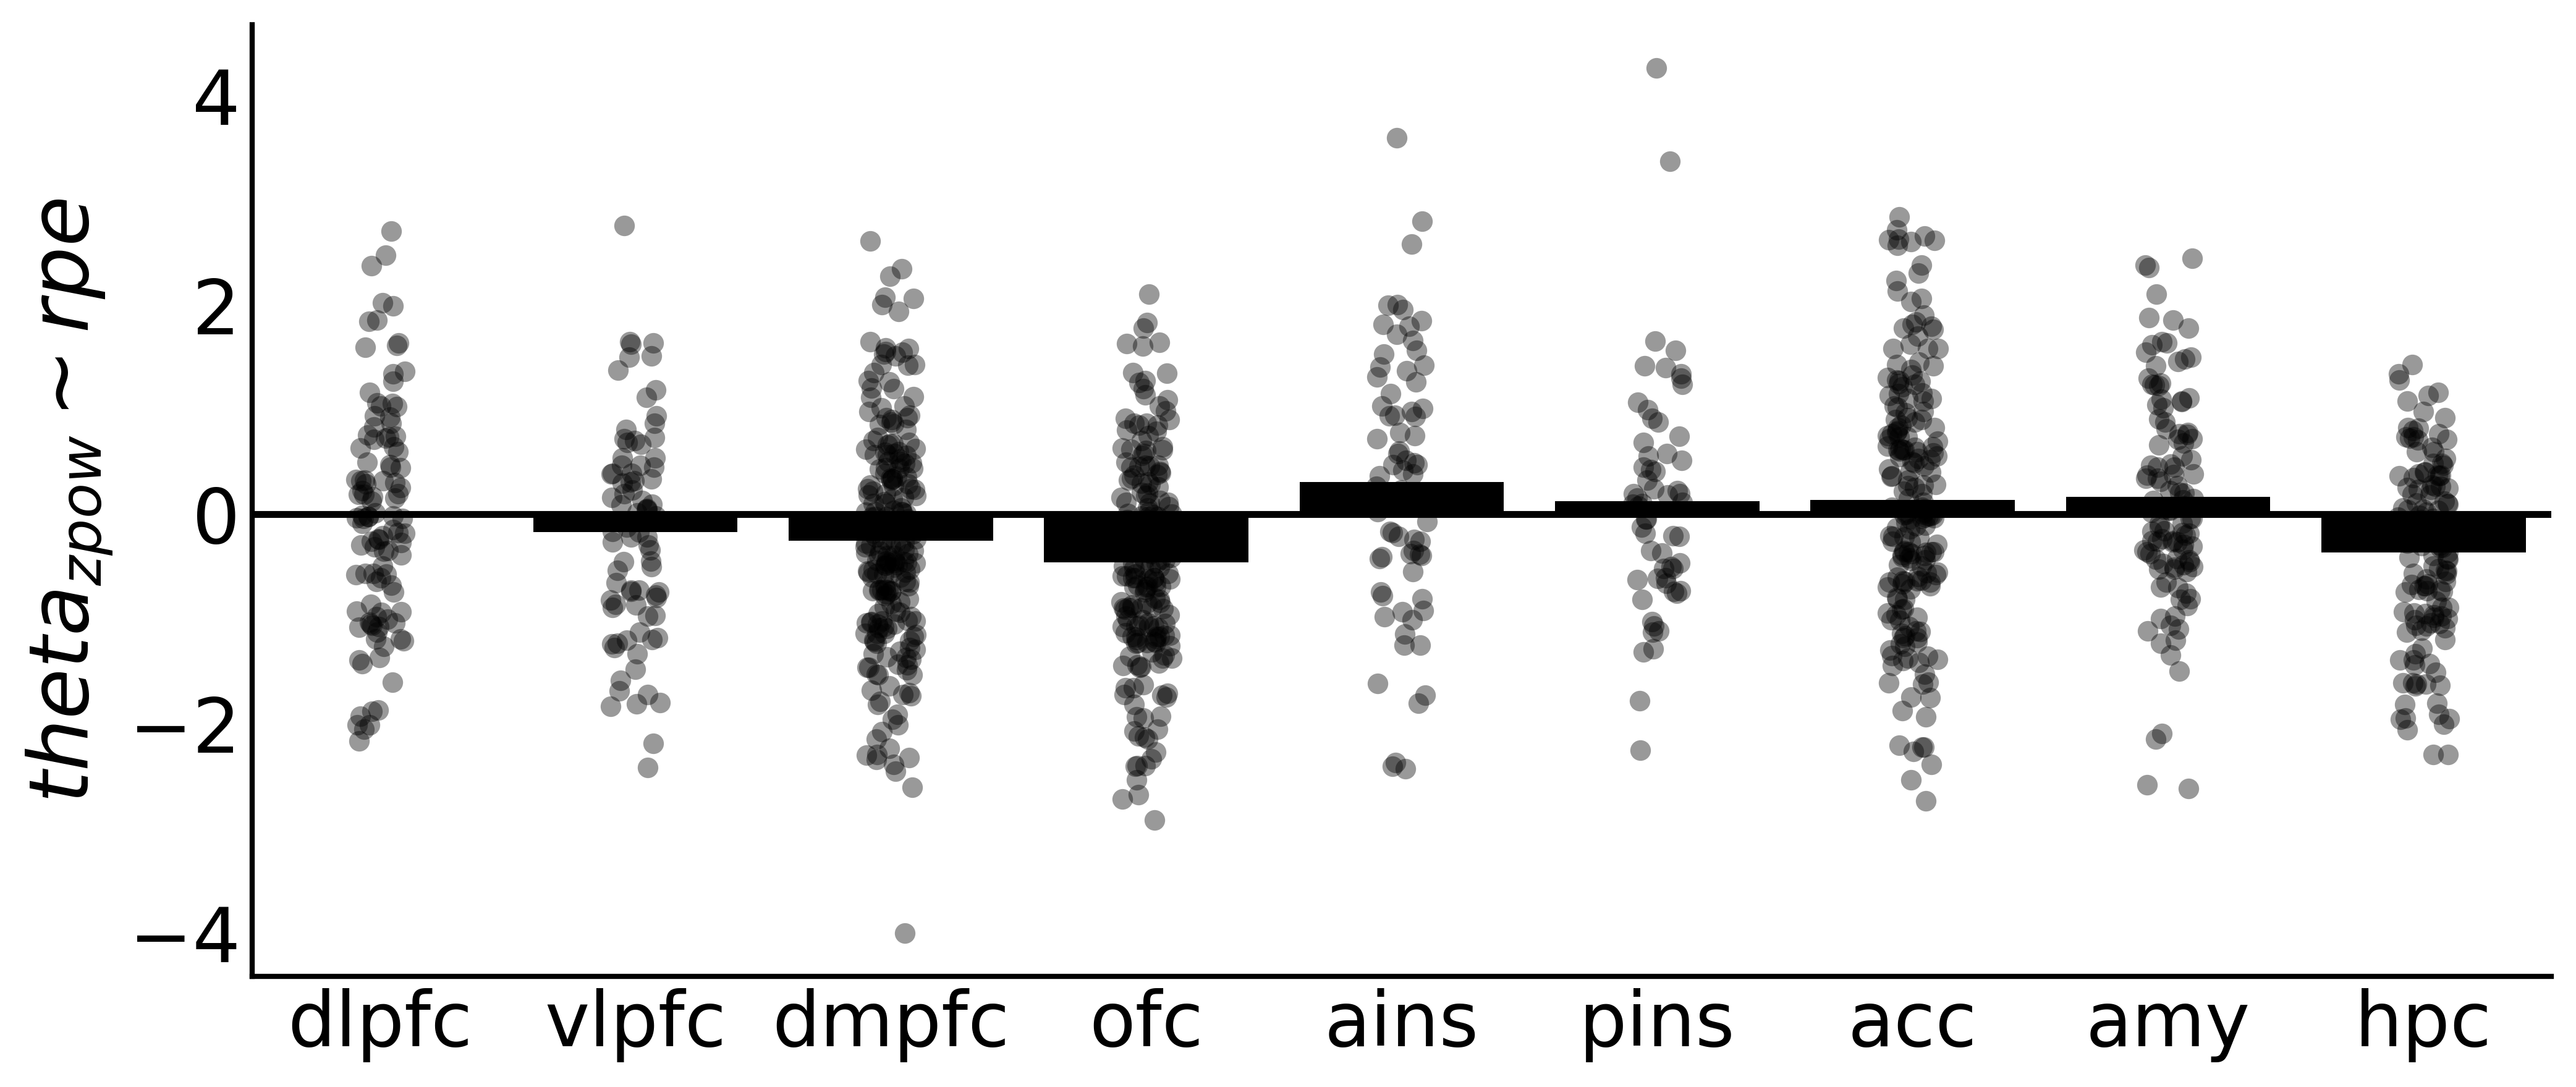

In [27]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim rpe$'


plot_roi_model_results(results,'roi',rpe_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

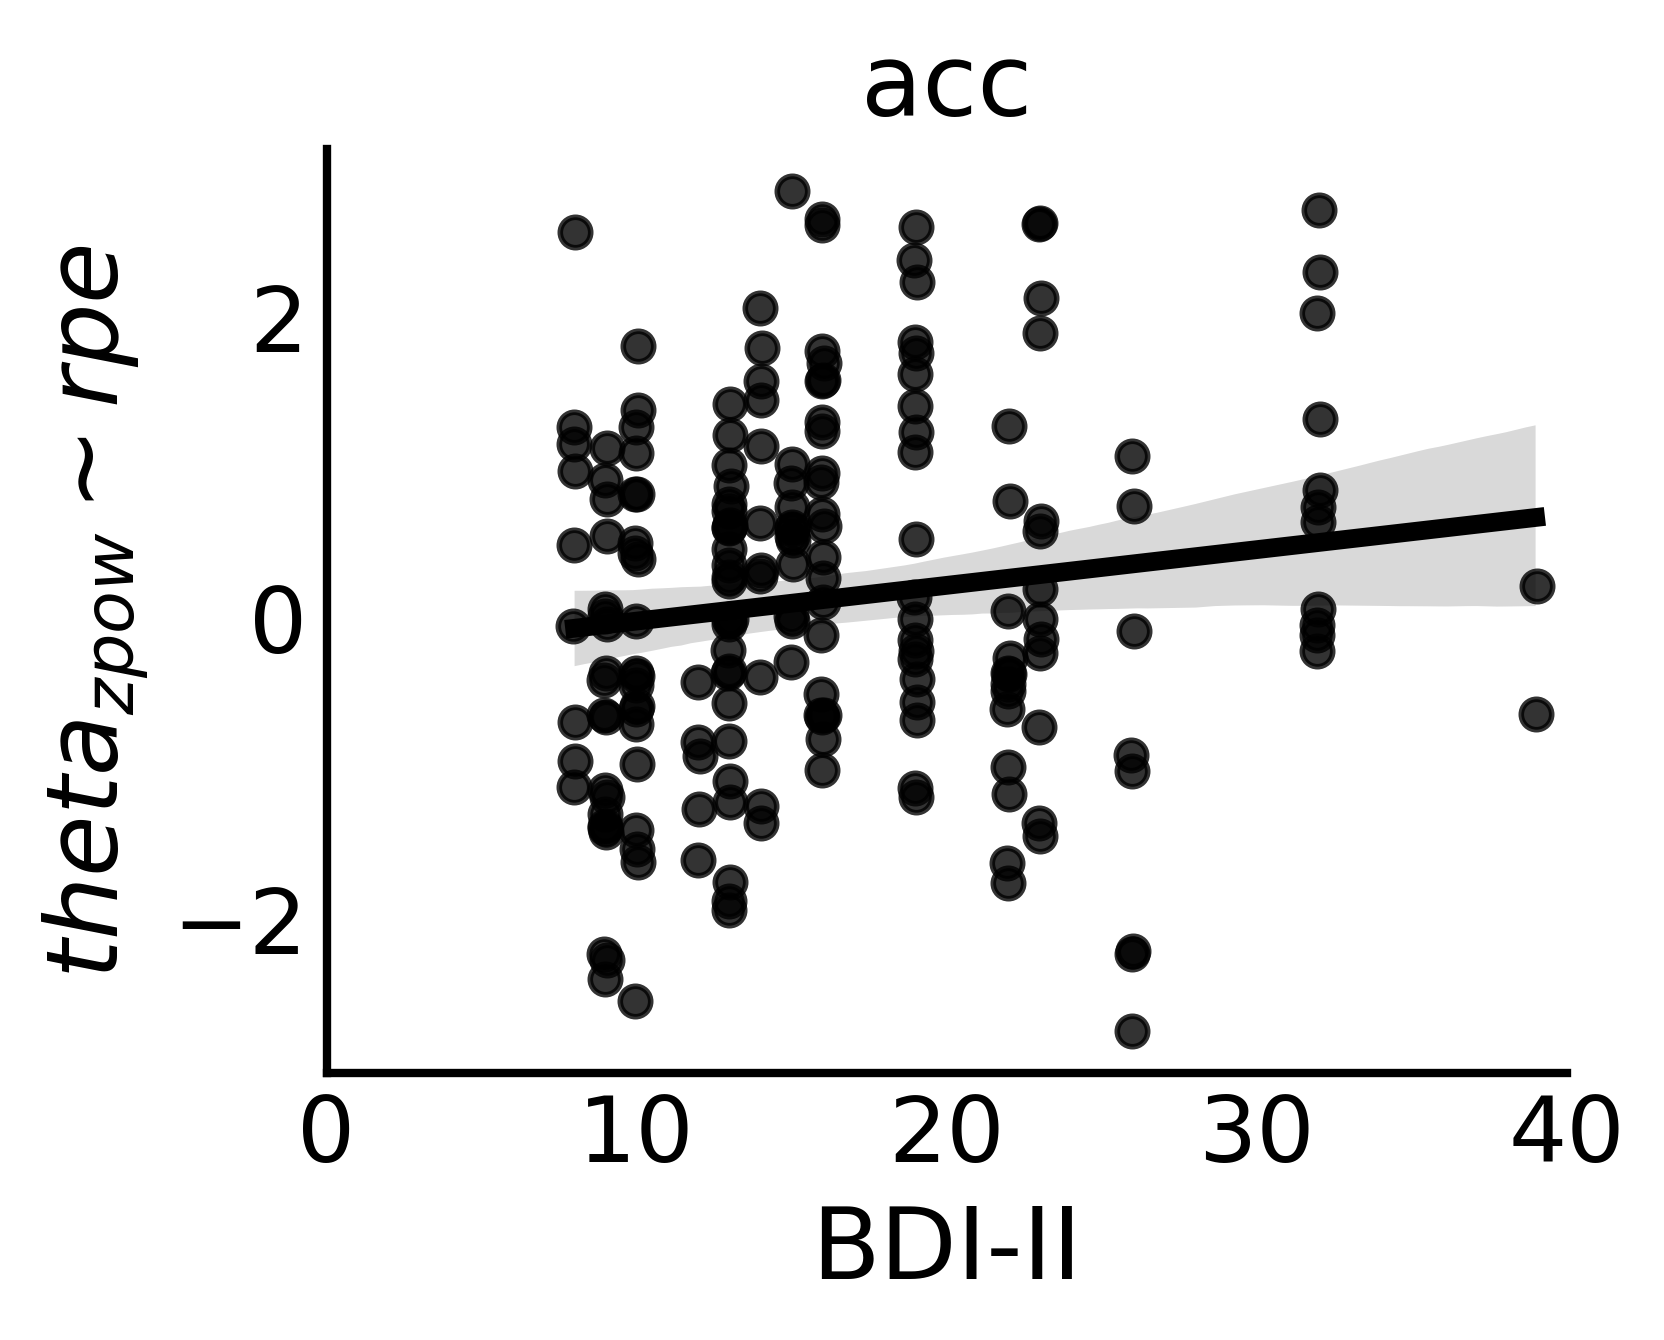

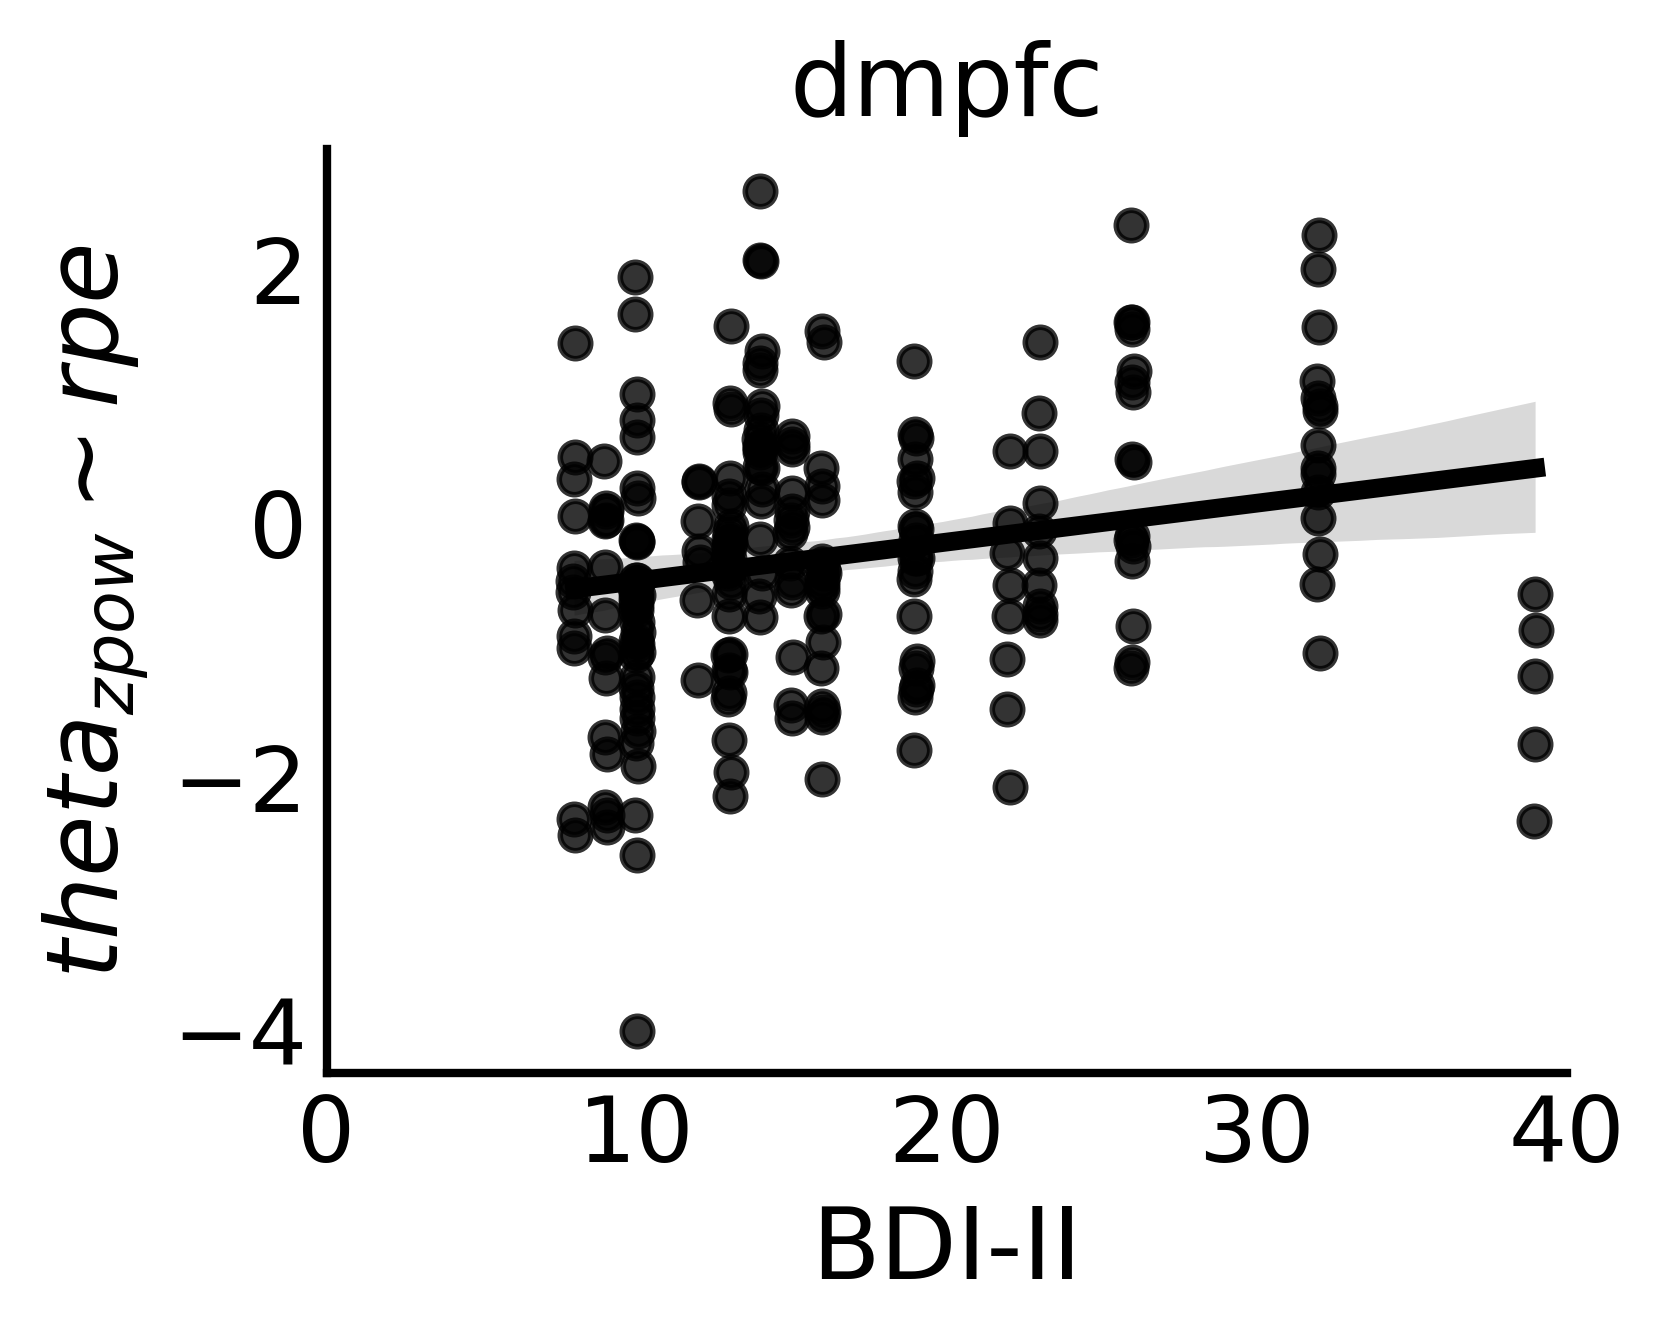

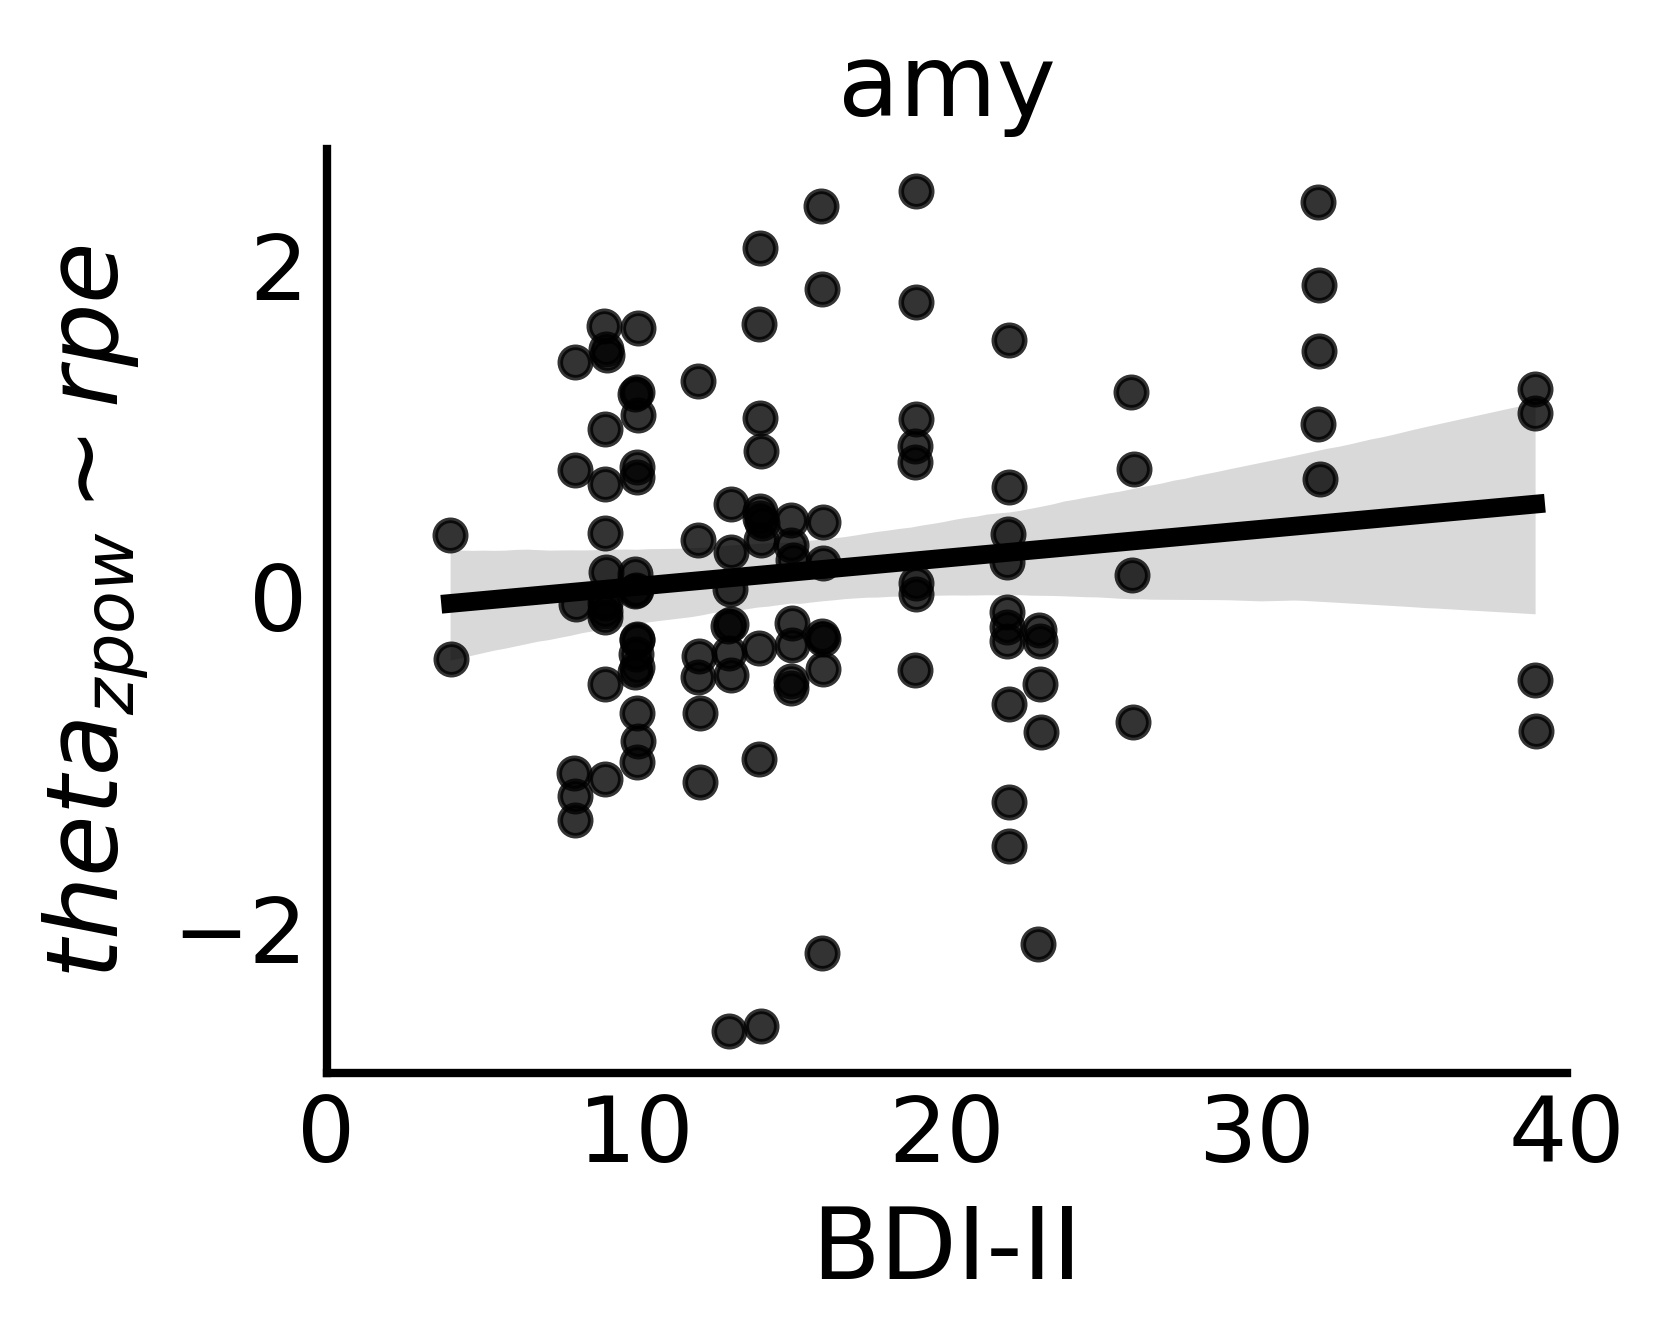

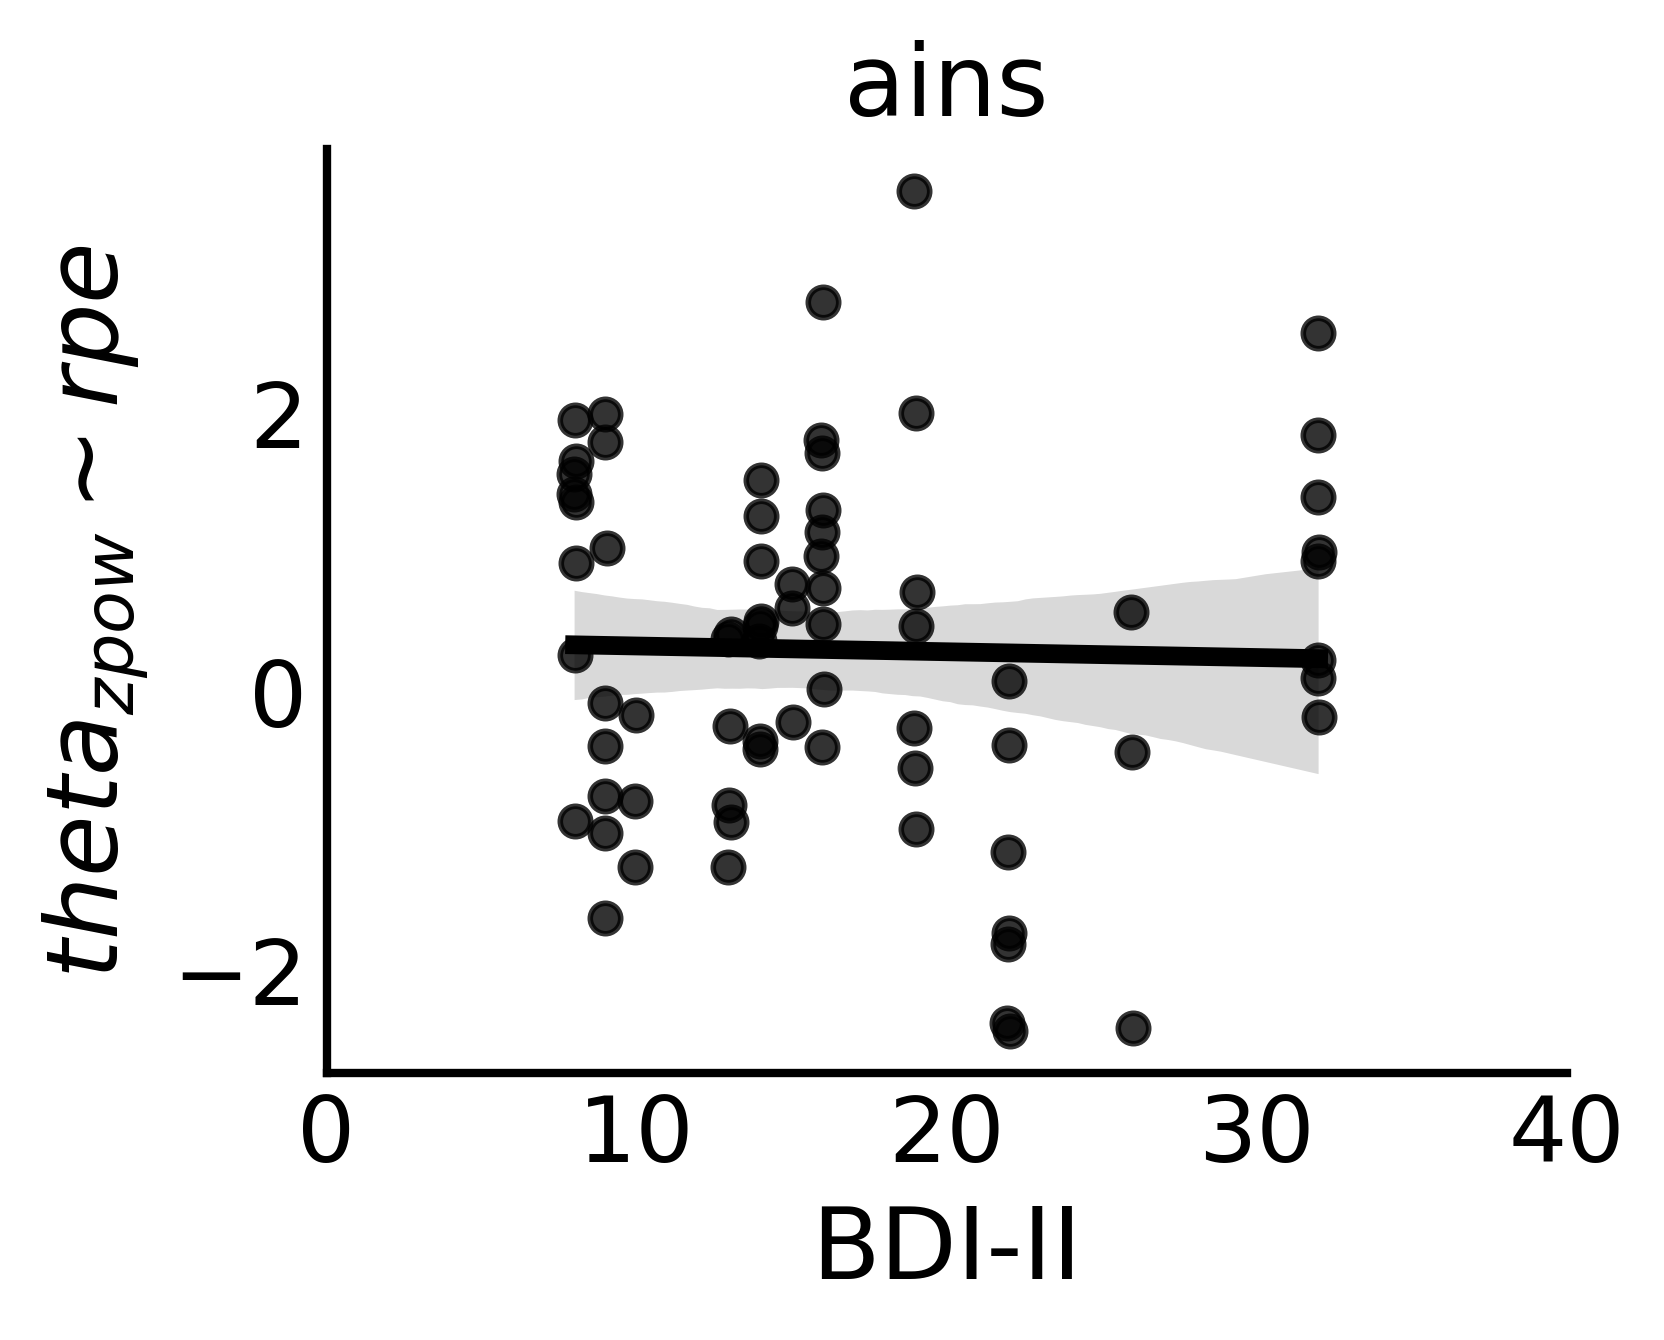

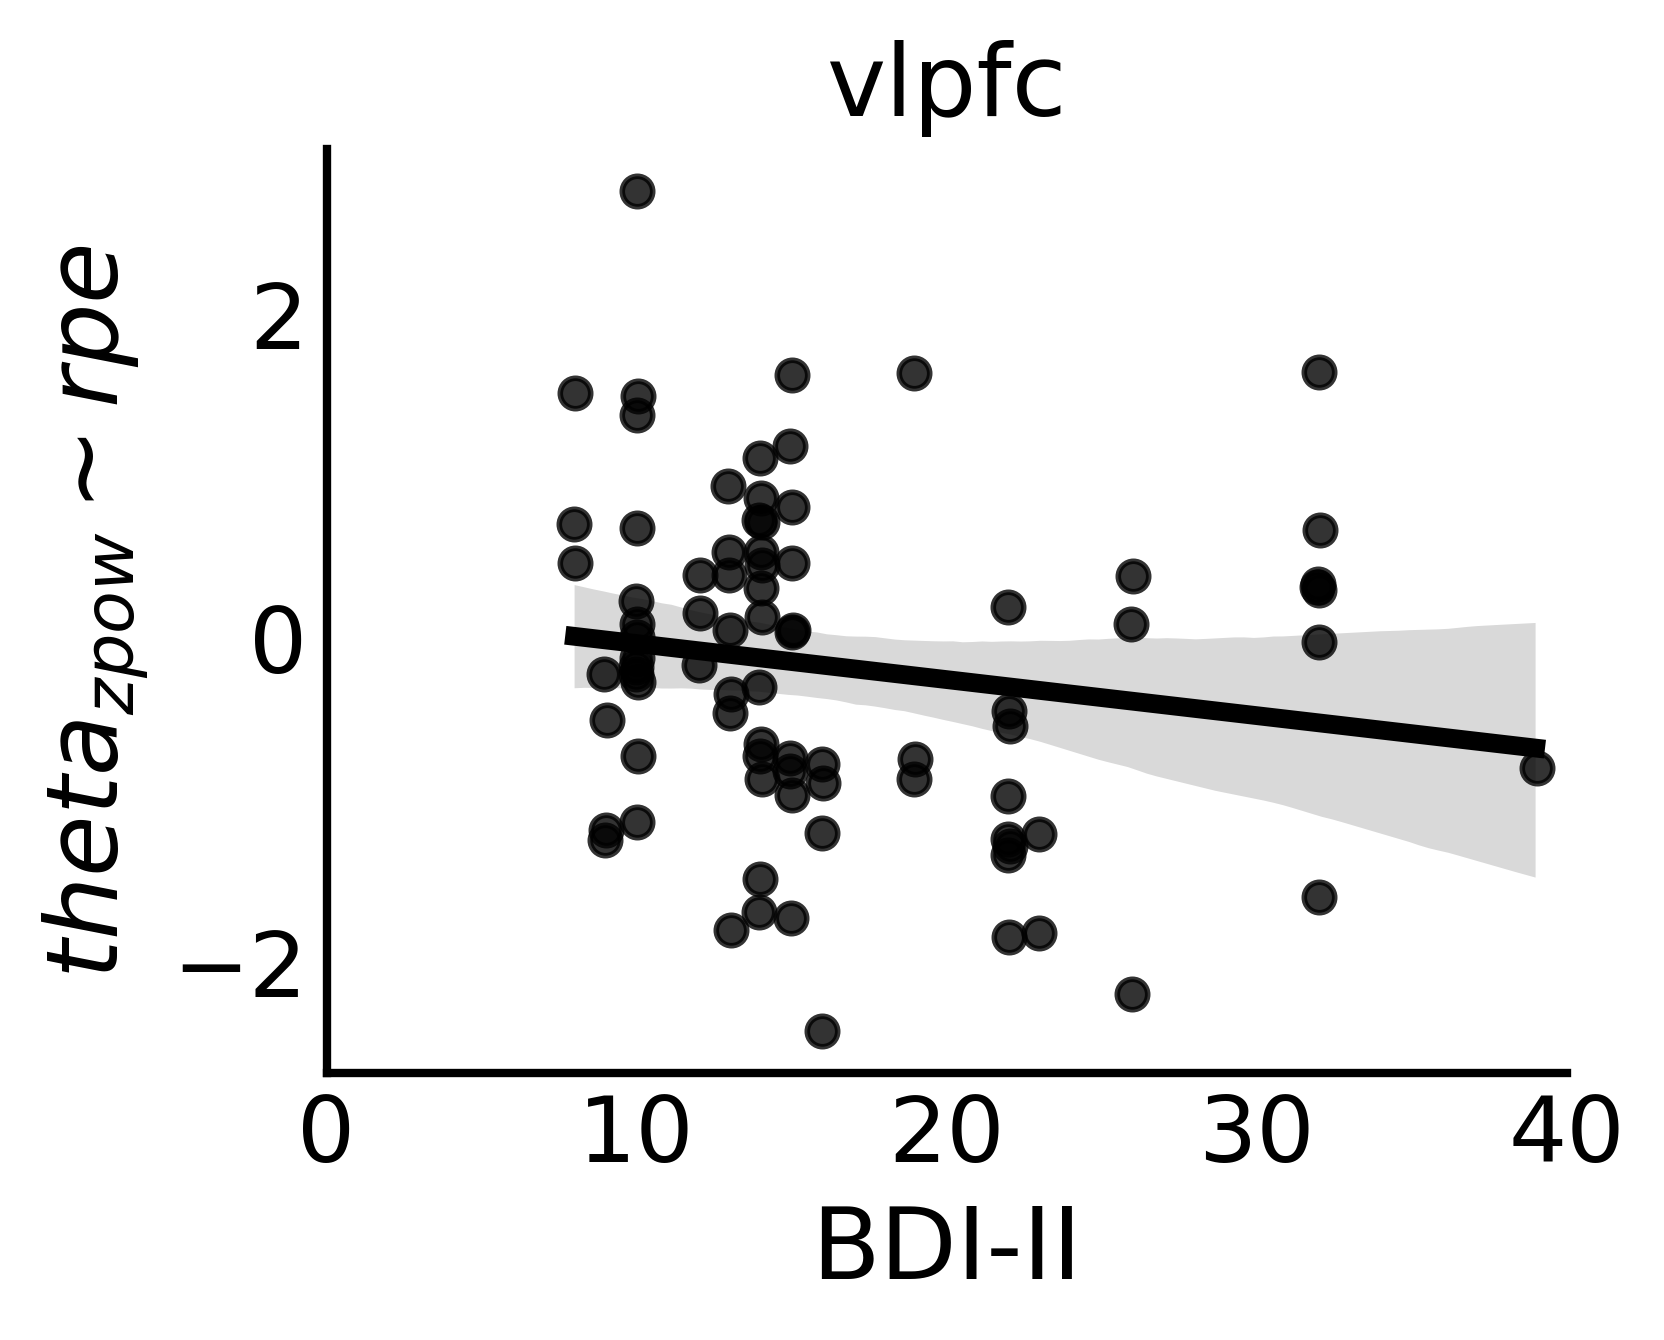

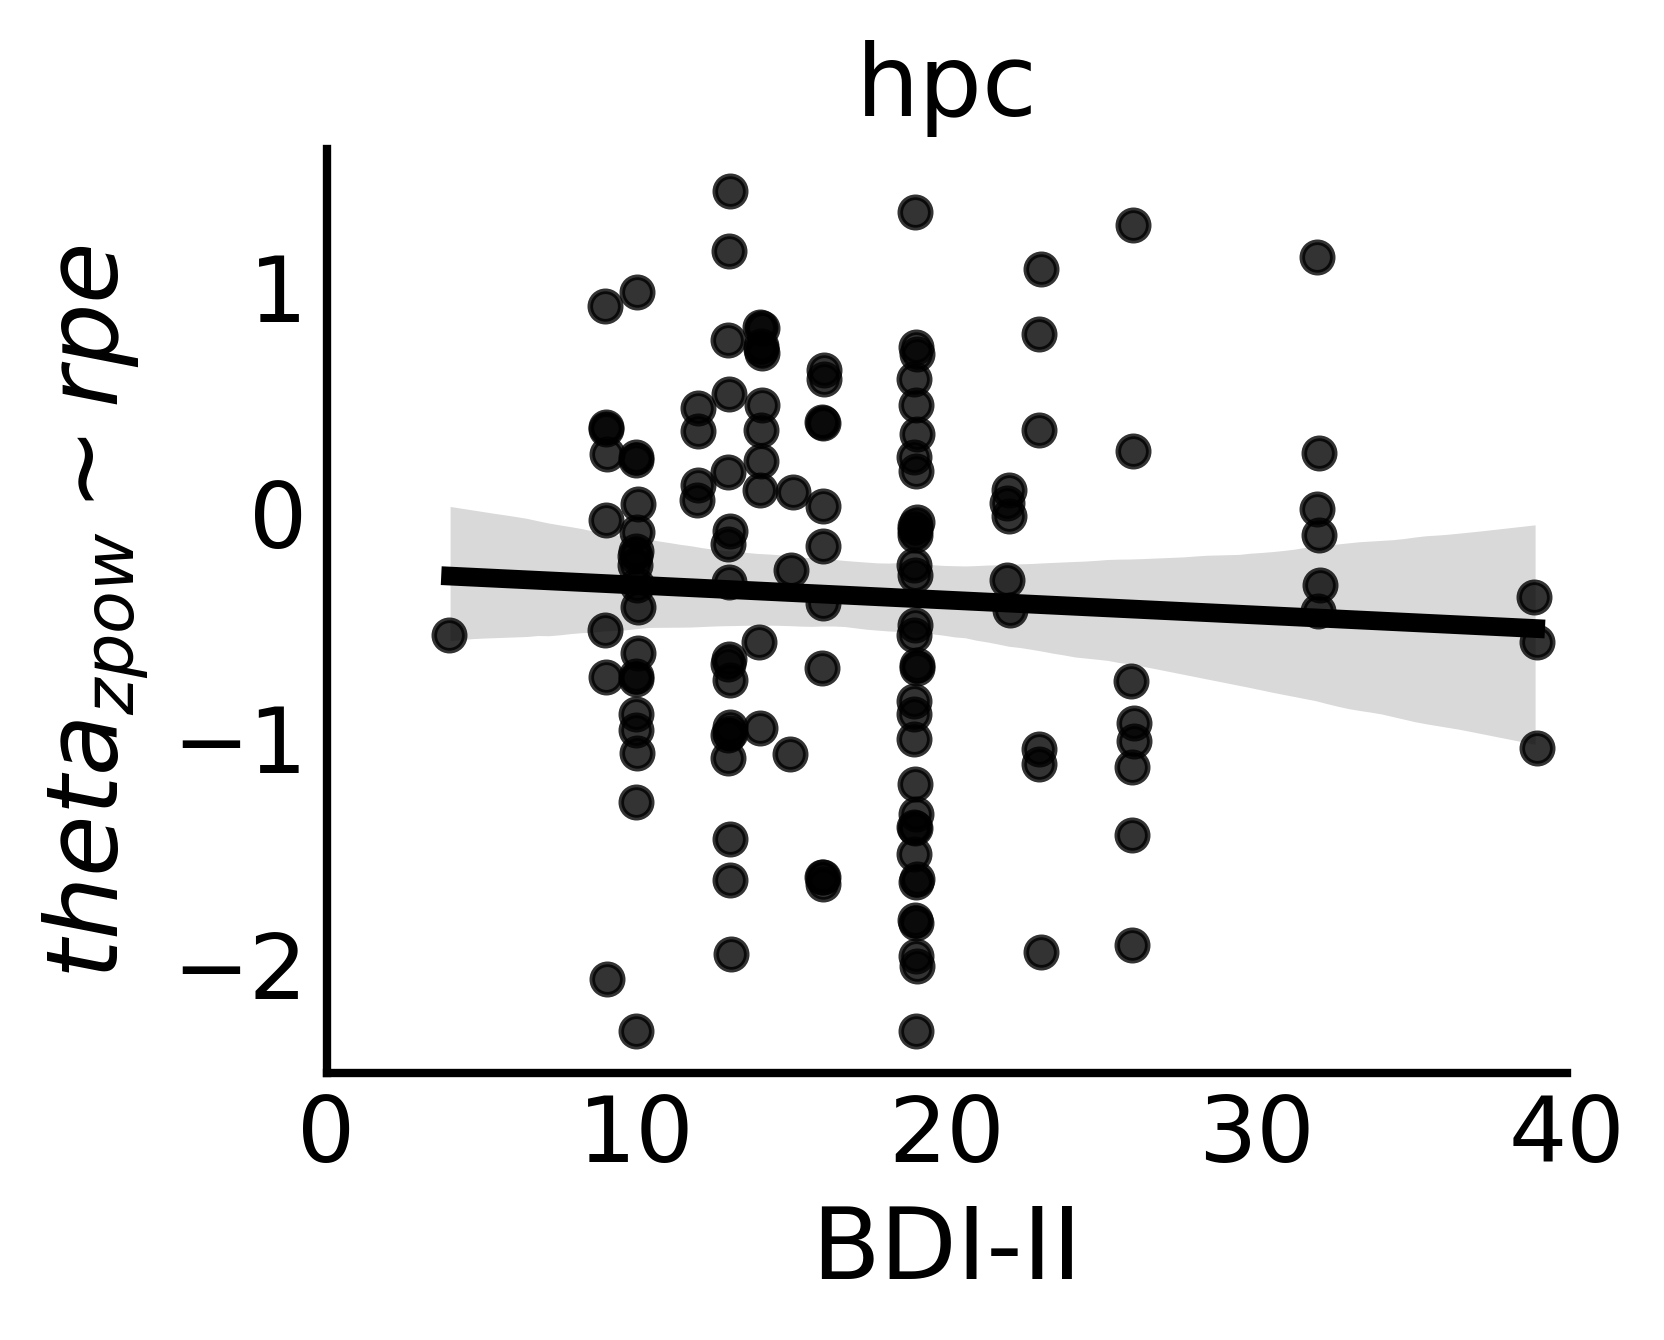

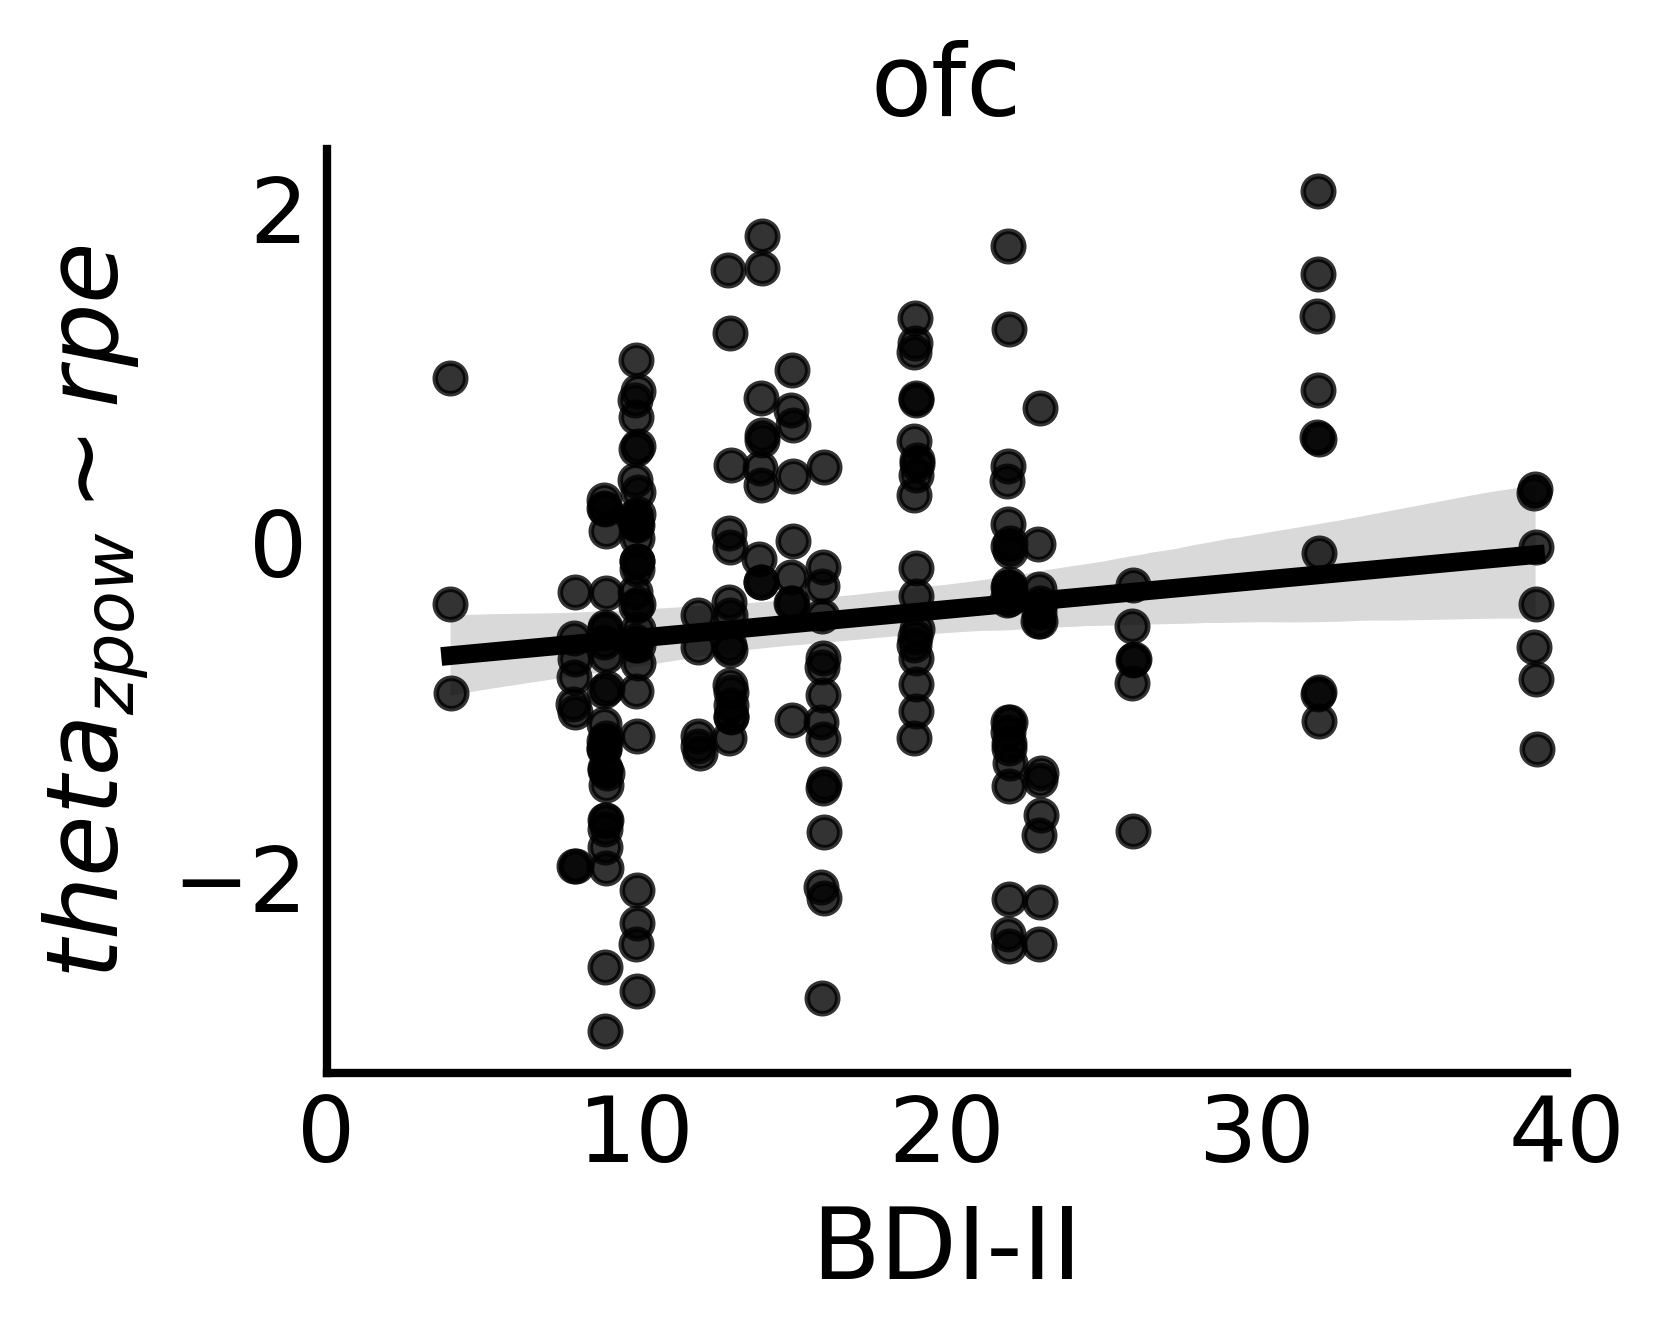

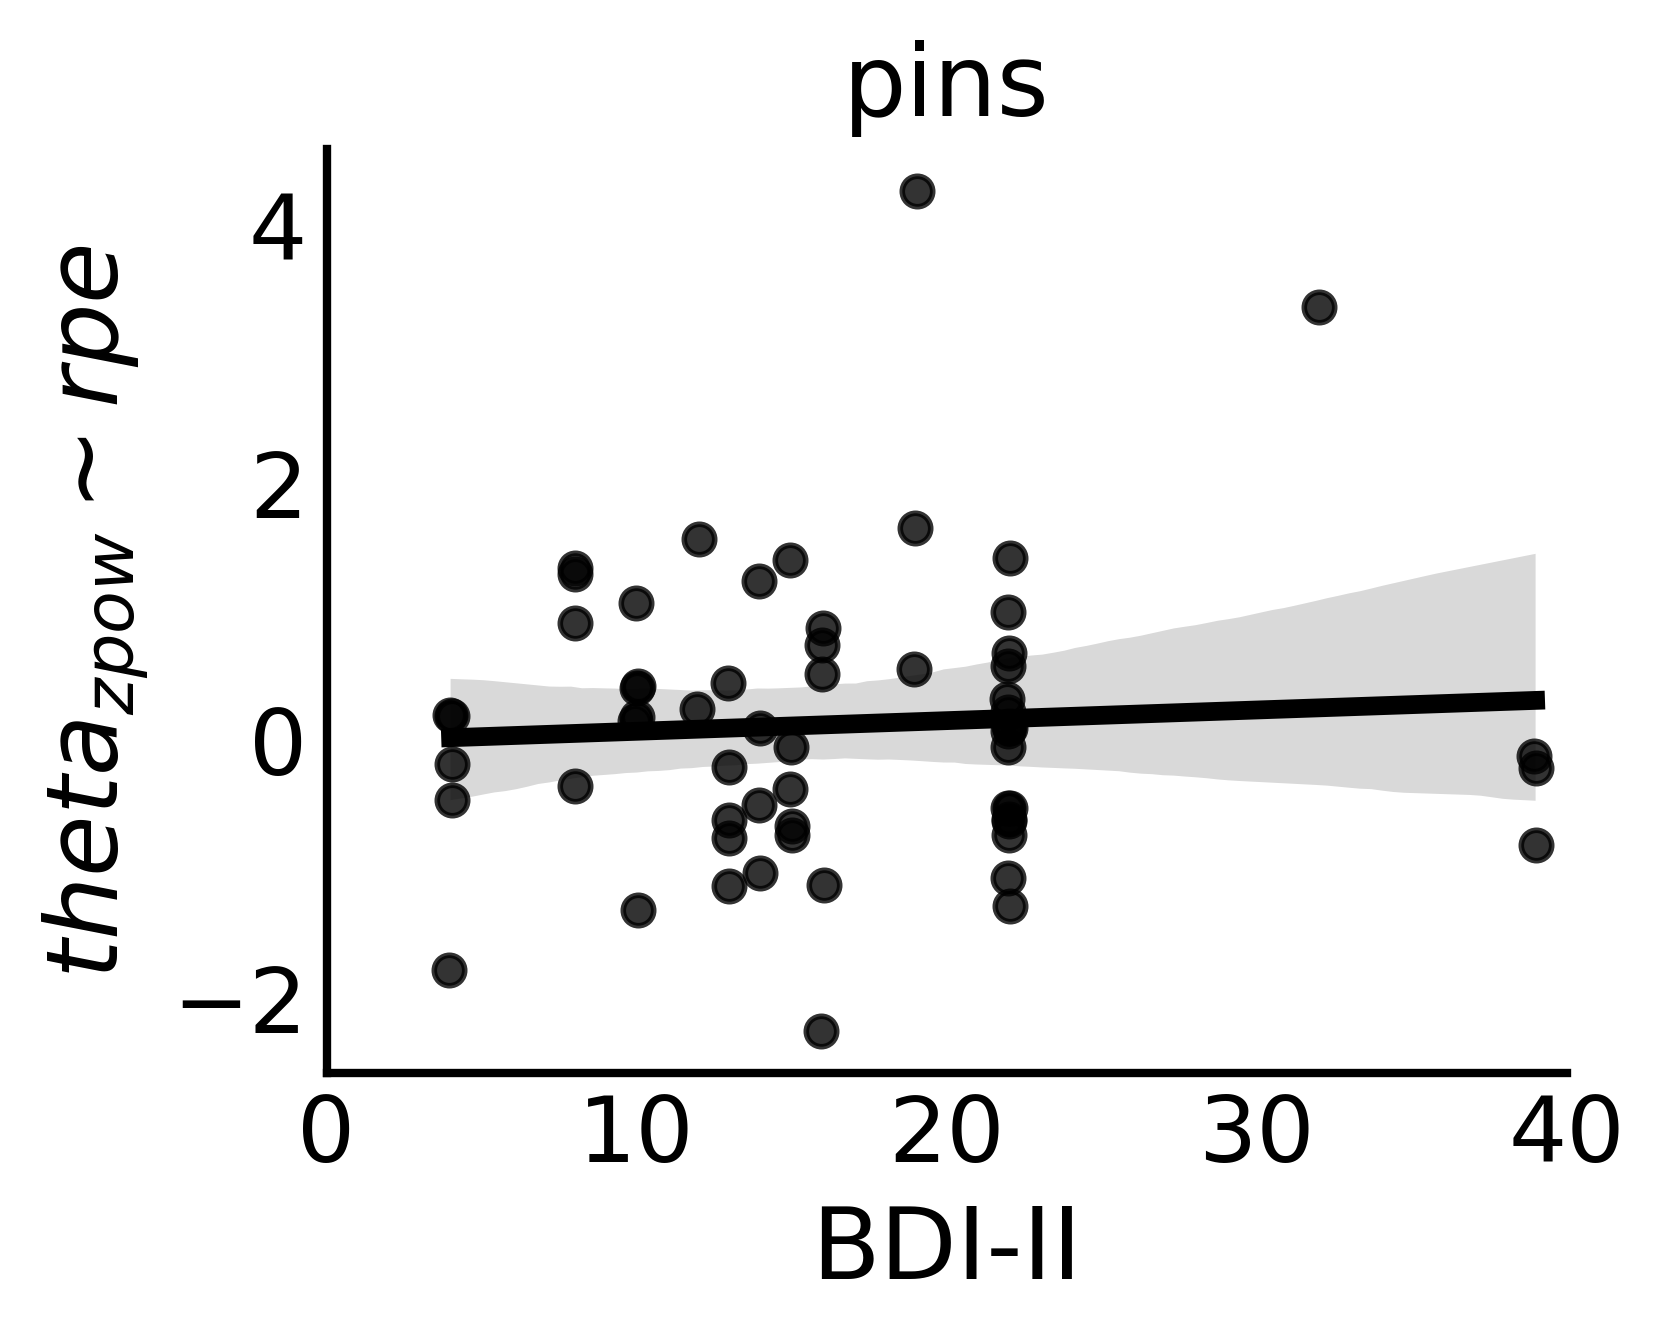

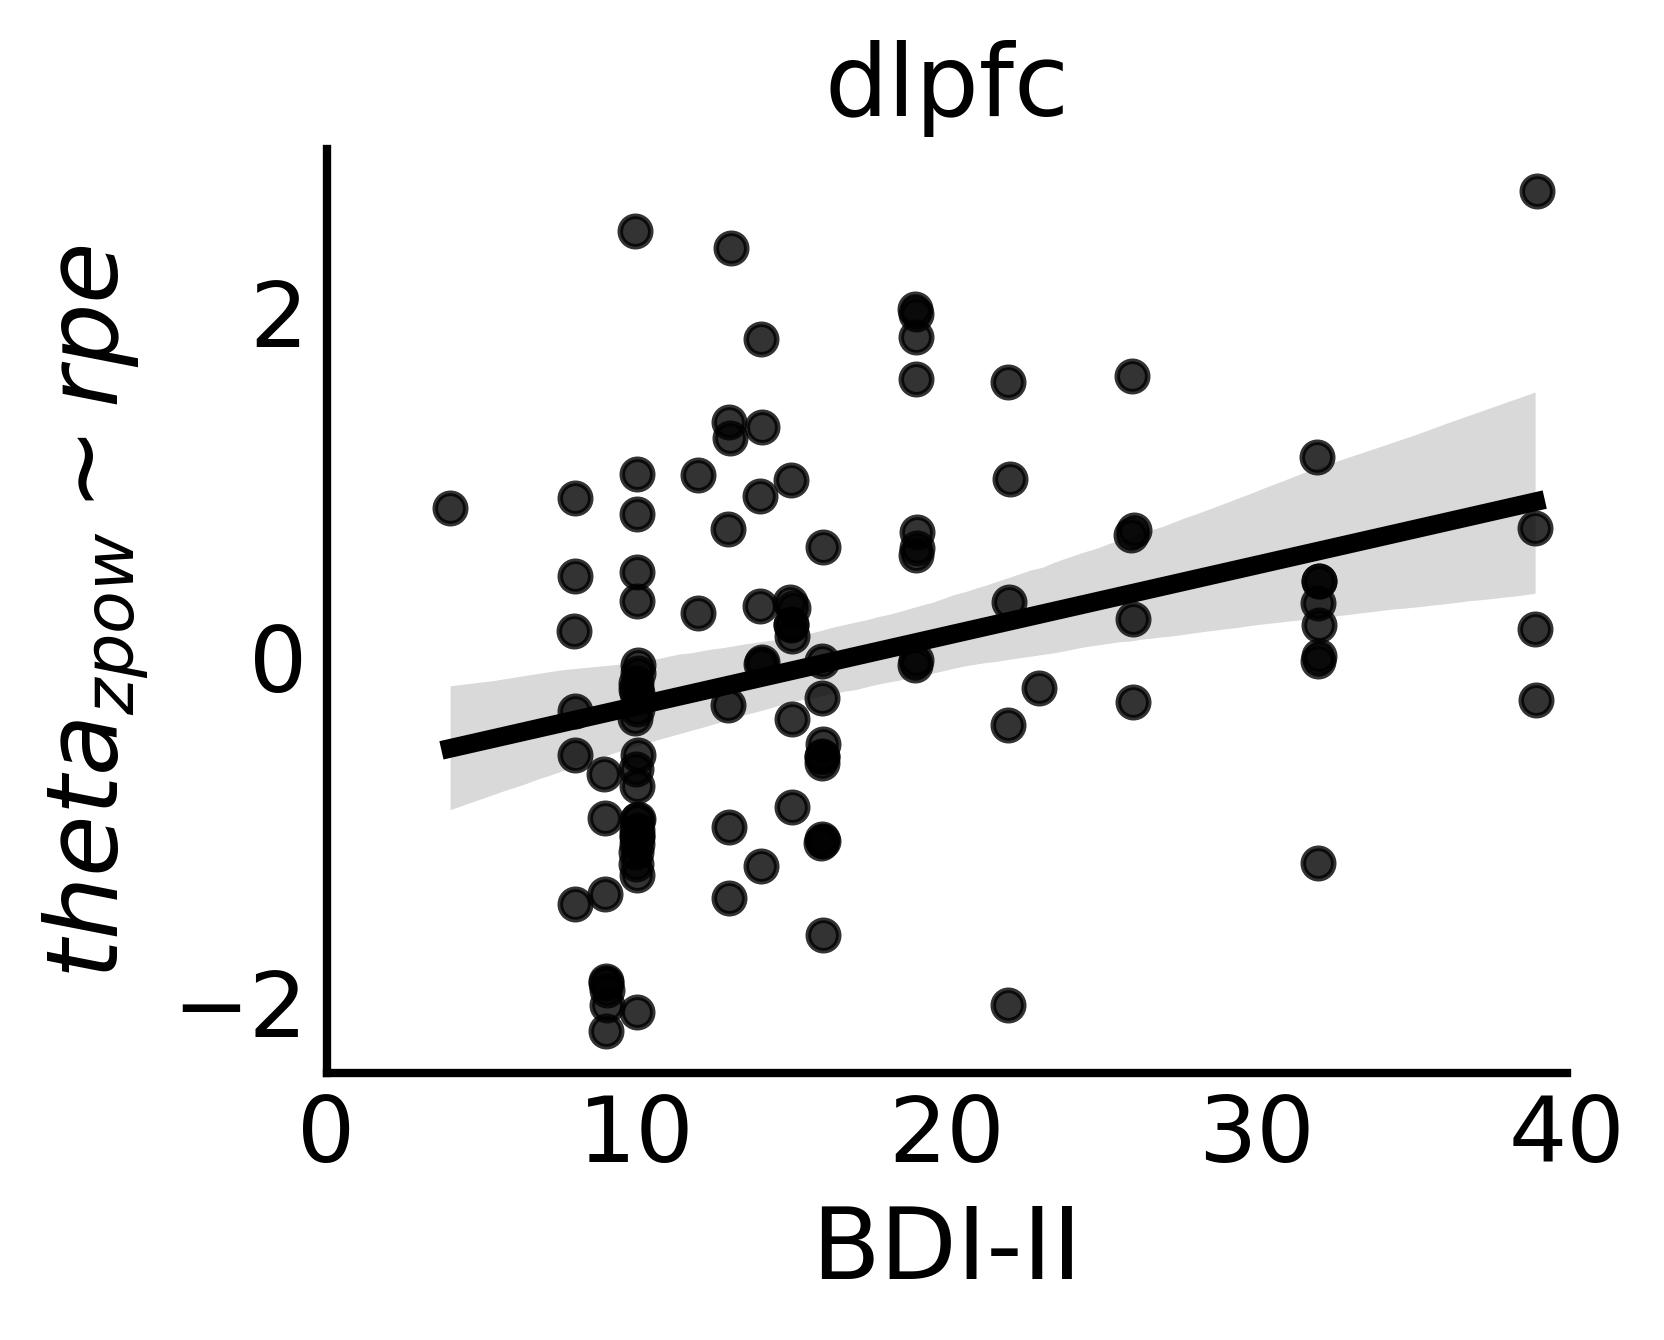

In [28]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_rpemodel_rpe-coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_rpe',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim rpe$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [29]:
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_rpe.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2024                                         
Time:                        11:06:08                                         
No. Iterations:                    13                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.5506      0.428     36.342     

# PROFIT ONLY MODELS

In [30]:
elec_col    = 'unique_reref_ch'
main_var    = 'Profit'
# reg_formula = 'band_pow~GambleChoice+TotalProfit+cpe'
reg_formula = 'band_pow~GambleChoice+TrialEV+Profit'

n_permutations = 1000
results_dict, main_var_sig = run_individual_elec_regression(theta_reg_df,reg_formula,elec_col, main_var,n_permutations)



Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2970.62it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3014.14it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 3063.20it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2944.11it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2969.80it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2955.38it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2950.80it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2967.20it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2961.08it/s]


Permutations: 100%|██████████| 1000/1000 [00:00<00:00, 2964.44it/s]


In [31]:
save_vars = results_dict['MS002_lacas1-lacas2'].index.tolist()
save_vars


['Intercept', 'GambleChoice[T.safe]', 'TrialEV', 'Profit']

In [32]:
results = single_elec_permutation_results(results_dict,theta_reg_df,save_vars)
results

unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
0     MS002_lacas1-lacas2   MS002    acc   14                     0.177301   
1     MS002_lacas2-lacas3   MS002    acc   14                     0.030327   
2     MS002_lacas3-lacas4   MS002    acc   14                     0.102369   
3     MS002_lacas4-lacas5   MS002    acc   14                     0.079312   
4     MS002_lacas5-lacas6   MS002    acc   14                     0.153066   
...                   ...     ...    ...  ...                          ...   
1183  DA039_rpins1-rpins2   DA039   pins   22                     0.144183   
1184  DA039_rpins2-rpins3   DA039   pins   22                    -0.051665   
1185  DA039_rpins3-rpins4   DA039   pins   22                    -0.012048   
1186  DA039_rsgcc6-rsgcc7   DA039  vlpfc   22                    -0.113565   
1187  DA039_rsgcc7-rsgcc8   DA039  vlpfc   22                    -0.135892   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                                  -0.119556                  -0.051534   
1                                   0.093792                  -0.134123   
2                                   0.023301                  -0.051012   
3                                   0.025794                   0.203321   
4                                   0.039854                   0.054895   
...                                      ...                        ...   
1183                               -0.003958                   0.075312   
1184                                0.170007                   0.223541   
1185                                0.024703                   0.007907   
1186                                0.116042                  -0.035697   
1187                                0.128973                   0.051098   

      Original_Estimate_Profit  Permuted_Mean_Intercept  \
0                     0.052916                 0.094222   
1                     0.176190                 0.094182   
2                    -0.108143                 0.117557   
3                    -0.094448                 0.100193   
4                    -0.018562                 0.180615   
...                        ...                      ...   
1183                 -0.048584                 0.146329   
1184                 -0.007095                 0.026384   
1185                 -0.069639                -0.003555   
1186                 -0.007285                -0.068880   
1187                 -0.130762                -0.083133   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TrialEV  \
0                               0.000082  ...              0.103661   
1                               0.001703  ...              0.121499   
2                               0.000802  ...              0.097667   
3                              -0.003621  ...              0.105793   
4                               0.000338  ...              0.111008   
...                                  ...  ...                   ...   
1183                           -0.001544  ...              0.122984   
1184                            0.003086  ...              0.101662   
1185                            0.001911  ...              0.097328   
1186                           -0.000597  ...              0.093739   
1187                           -0.002189  ...              0.099781   

      Permuted_Std_Profit  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
0                0.099301           1.536242                     -1.536948   
1                0.117294          -0.968317                      0.970106   
2                0.099471          -0.275067                      0.283089   
3                0.105353          -0.320162                      0.313264   
4                0.108398          -0.412323                      0.410844   
...                   ...                ...                           ...   
1183             0.104245          -0.049938                     

### Save results as pickle file

In [33]:
save_path = f'{save_dir}/{band}/'
os.makedirs(save_path, exist_ok=True)

fname = f'{save_path}{band}_perm_regression_results_Profitmodel_{date}.pkl'
pickle.dump(results, open(fname,"wb"))

In [34]:
sig_data = results[results.P_Value_Profit < 0.05]
sig_data



unique_elec_id subj_id    roi  bdi  Original_Estimate_Intercept  \
21    MS002_laims13-laims14   MS002  dmpfc   14                     0.188147   
26      MS002_lloif1-lloif2   MS002    ofc   14                     0.293175   
48      MS002_racas1-racas2   MS002    acc   14                    -0.021610   
57      MS002_ragit3-ragit4   MS002    amy   14                     0.029659   
62    MS002_raims10-raims11   MS002  dlpfc   14                     0.075657   
...                     ...     ...    ...  ...                          ...   
1160    DA039_rains4-rains5   DA039   ains   22                    -0.060457   
1164    DA039_rains8-rains9   DA039  vlpfc   22                    -0.064490   
1172        DA039_rof1-rof2   DA039    ofc   22                    -0.126482   
1176        DA039_rof5-rof6   DA039    ofc   22                    -0.043932   
1177        DA039_rof6-rof7   DA039  dlpfc   22                    -0.065121   

      Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
21                                 -0.025667                  -0.265399   
26                                 -0.068988                  -0.145352   
48                                  0.036899                  -0.044725   
57                                 -0.072225                   0.108739   
62                                  0.176572                  -0.266778   
...                                      ...                        ...   
1160                                0.049093                   0.213848   
1164                                0.035888                   0.140000   
1172                                0.123312                   0.106778   
1176                                0.005078                   0.124382   
1177                                0.141476                   0.234545   

      Original_Estimate_Profit  Permuted_Mean_Intercept  \
21                    0.403627                 0.171452   
26                    0.291783                 0.244092   
48                    0.217319                 0.005826   
57                   -0.124106                -0.021739   
62                    0.277097                 0.199242   
...                        ...                      ...   
1160                 -0.217678                -0.034214   
1164                 -0.195008                -0.045960   
1172                 -0.232750                -0.076280   
1176                 -0.223010                -0.038598   
1177                 -0.192632                -0.000890   

      Permuted_Mean_GambleChoice[T.safe]  ...  Permuted_Std_TrialEV  \
21                             -0.001590  ...              0.131906   
26                              0.002000  ...              0.127441   
48                             -0.002142  ...              0.086553   
57                              0.001976  ...              0.059992   
62                             -0.001950  ...              0.129071   
...                                  ...  ...                   ...   
1160                            0.001980  ...              0.112767   
1164                           -0.000122  ...              0.106331   
1172                            0.001676  ...              0.093143   
1176                           -0.000670  ...              0.117607   
1177                            0.002531  ...              0.099975   

      Permuted_Std_Profit  Z_Score_Intercept  Z_Score_GambleChoice[T.safe]  \
21               0.140182           0.221542                     -0.221990   
26               0.122718           0.697667                     -0.701089   
48               0.087294          -0.555603                      0.549198   
57               0.059184           1.517233                     -1.521610   
62               0.127776          -1.707334                      1.713611   
...                   ...                ...                           ...   
1160             0.101800          -0.67594

In [35]:
sig_data.roi.value_counts()



roi
acc      22
ofc      16
dmpfc    15
dlpfc    11
amy       7
ains      6
vlpfc     5
pins      4
hpc       4
Name: count, dtype: int64

In [36]:
sig_data.roi.unique()



array(['dmpfc', 'ofc', 'acc', 'amy', 'dlpfc', 'pins', 'ains', 'vlpfc',
       'hpc'], dtype=object)

### ROI Significance Testing
- % of sig elecs in ROI (also split by BDI)
- binomial test for whether sig proportion of elecs in ROI 
- ttests from zero 


In [37]:
# add mask col for sig cpe elecs 
results['Profit_sig']   = results['P_Value_Profit'].apply(lambda x: 0 if x > 0.05 else 1)
results['bdi_split'] = results['bdi'].apply(lambda x: 0 if x < 20 else 1)

results.head()

# results.to_csv(f'{save_path}{band}_perm_regression_results_df_{epoch_len}.csv')

unique_elec_id subj_id  roi  bdi  Original_Estimate_Intercept  \
0  MS002_lacas1-lacas2   MS002  acc   14                     0.177301   
1  MS002_lacas2-lacas3   MS002  acc   14                     0.030327   
2  MS002_lacas3-lacas4   MS002  acc   14                     0.102369   
3  MS002_lacas4-lacas5   MS002  acc   14                     0.079312   
4  MS002_lacas5-lacas6   MS002  acc   14                     0.153066   

   Original_Estimate_GambleChoice[T.safe]  Original_Estimate_TrialEV  \
0                               -0.119556                  -0.051534   
1                                0.093792                  -0.134123   
2                                0.023301                  -0.051012   
3                                0.025794                   0.203321   
4                                0.039854                   0.054895   

   Original_Estimate_Profit  Permuted_Mean_Intercept  \
0                  0.052916                 0.094222   
1                  0.176190                 0.094182   
2                 -0.108143                 0.117557   
3                 -0.094448                 0.100193   
4                 -0.018562                 0.180615   

   Permuted_Mean_GambleChoice[T.safe]  ...  Z_Score_Intercept  \
0                            0.000082  ...           1.536242   
1                            0.001703  ...          -0.968317   
2                            0.000802  ...          -0.275067   
3                           -0.003621  ...          -0.320162   
4                            0.000338  ...          -0.412323   

   Z_Score_GambleChoice[T.safe]  Z_Score_TrialEV  Z_Score_Profit  \
0                     -1.536948        -0.546380        0.555509   
1                      0.970106        -1.056665        1.459406   
2                      0.283089        -0.533177       -1.085520   
3                      0.313264         1.896167       -0.866831   
4                      0.410844         0.453155       -0.164955   

   P_Value_Intercept  P_Value_GambleChoice[T.safe]  P_Value_TrialEV  \
0           0.124479                      0.124306         0.584805   
1           0.332886                      0.331994         0.290664   
2           0.783265                      0.777109         0.593911   
3           0.748846                      0.754080         0.057938   
4           0.680103                      0.681187         0.650437   

   P_Value_Profit  Profit_sig  bdi_split  
0        0.578547           0          0  
1        0.144453           0          0  
2        0.277691           0          0  
3        0.386035           0          0  
4        0.868980           0          0  

[5 rows x 26 columns]

In [38]:
Profit_var = 'Z_Score_Profit'

In [39]:
# bar_order = ['dlpfc','vlpfc','dmpfc','ofc','ains','pins', 'acc','hpc','amy']
bar_order = keep_rois.copy()


In [40]:
results.groupby('roi').agg('mean',numeric_only=True)[Profit_var][bar_order]



roi
dlpfc   -0.073990
vlpfc   -0.181471
dmpfc   -0.274518
ofc     -0.491184
ains     0.226807
pins     0.195233
acc      0.115341
amy      0.181911
hpc     -0.376411
Name: Z_Score_Profit, dtype: float64

In [41]:
roi_sig_info = []

for roi in results.roi.unique().tolist():
    roi_results = results[results.roi==roi]
    # ttest from zero 
    ttest_stat,ttest_pval = ttest_1samp(roi_results[Profit_var],popmean=0)
    # binomial test for significance 
    n = len(roi_results)
    x = np.sum(roi_results.Profit_sig)
    binom_test = scipy.stats.binomtest(x, n, p=0.05, alternative='greater')
    binom_pval = binom_test.pvalue
    binom_prop = binom_test.statistic
    ci_low     = binom_test.proportion_ci(confidence_level=0.95).low
    ci_high    = binom_test.proportion_ci(confidence_level=0.95).high
    # agg results 
    roi_sig_info.append(pd.DataFrame({'roi':roi,'n_total':n,'n_sig':x,'prop_sig':np.divide(x,n),
                                      'n_sig_highbdi':np.sum(roi_results[roi_results.bdi_split==1].Profit_sig),
                                      'ttest_stat':ttest_stat,'ttest_pval':ttest_pval,
                                      'binom_ci_low':ci_low,'binom_ci_high':ci_high,
                                      'binom_prop':binom_prop,'binom_pval':np.round(binom_pval,4)},index=[0]))

roi_sig_info = pd.concat(roi_sig_info).reset_index(drop=True)

In [42]:
roi_sig_info

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     22  0.113990              8    1.336969  1.828147e-01   
1  dmpfc      225     15  0.066667              4   -3.986026  9.093364e-05   
2    amy      113      7  0.061947              2    1.969366  5.138045e-02   
3   ains       71      6  0.084507              4    1.561553  1.229033e-01   
4  vlpfc       82      5  0.060976              3   -1.606009  1.121638e-01   
5    hpc      135      4  0.029630              0   -4.856691  3.277162e-06   
6    ofc      202     16  0.079208              5   -6.978582  4.234998e-11   
7   pins       60      4  0.066667              1    1.403454  1.657228e-01   
8  dlpfc      107     11  0.102804              2   -0.676907  4.999392e-01   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.078443            1.0    0.113990      0.0003  
1      0.041540            1.0    0.066667      0.1592  
2      0.029432            1.0    0.061947      0.3362  
3      0.037443            1.0    0.084507      0.1440  
4      0.024331            1.0    0.060976      0.3912  
5      0.010183            1.0    0.029630      0.9099  
6      0.050312            1.0    0.079208      0.0478  
7      0.023091            1.0    0.066667      0.3527  
8      0.058729            1.0    0.102804      0.0183

In [43]:
sig_rois = roi_sig_info[roi_sig_info.binom_pval<0.05]
sig_rois

roi  n_total  n_sig  prop_sig  n_sig_highbdi  ttest_stat    ttest_pval  \
0    acc      193     22  0.113990              8    1.336969  1.828147e-01   
6    ofc      202     16  0.079208              5   -6.978582  4.234998e-11   
8  dlpfc      107     11  0.102804              2   -0.676907  4.999392e-01   

   binom_ci_low  binom_ci_high  binom_prop  binom_pval  
0      0.078443            1.0    0.113990      0.0003  
6      0.050312            1.0    0.079208      0.0478  
8      0.058729            1.0    0.102804      0.0183

# Plot Results

In [44]:
fig_save_path = f'{fig_dir}{band}/'
os.makedirs(fig_save_path, exist_ok=True)

fig_id = f'{band}_perm_regression_Profitonly_Profit-coeff_barplot_{epoch_len}.pdf'


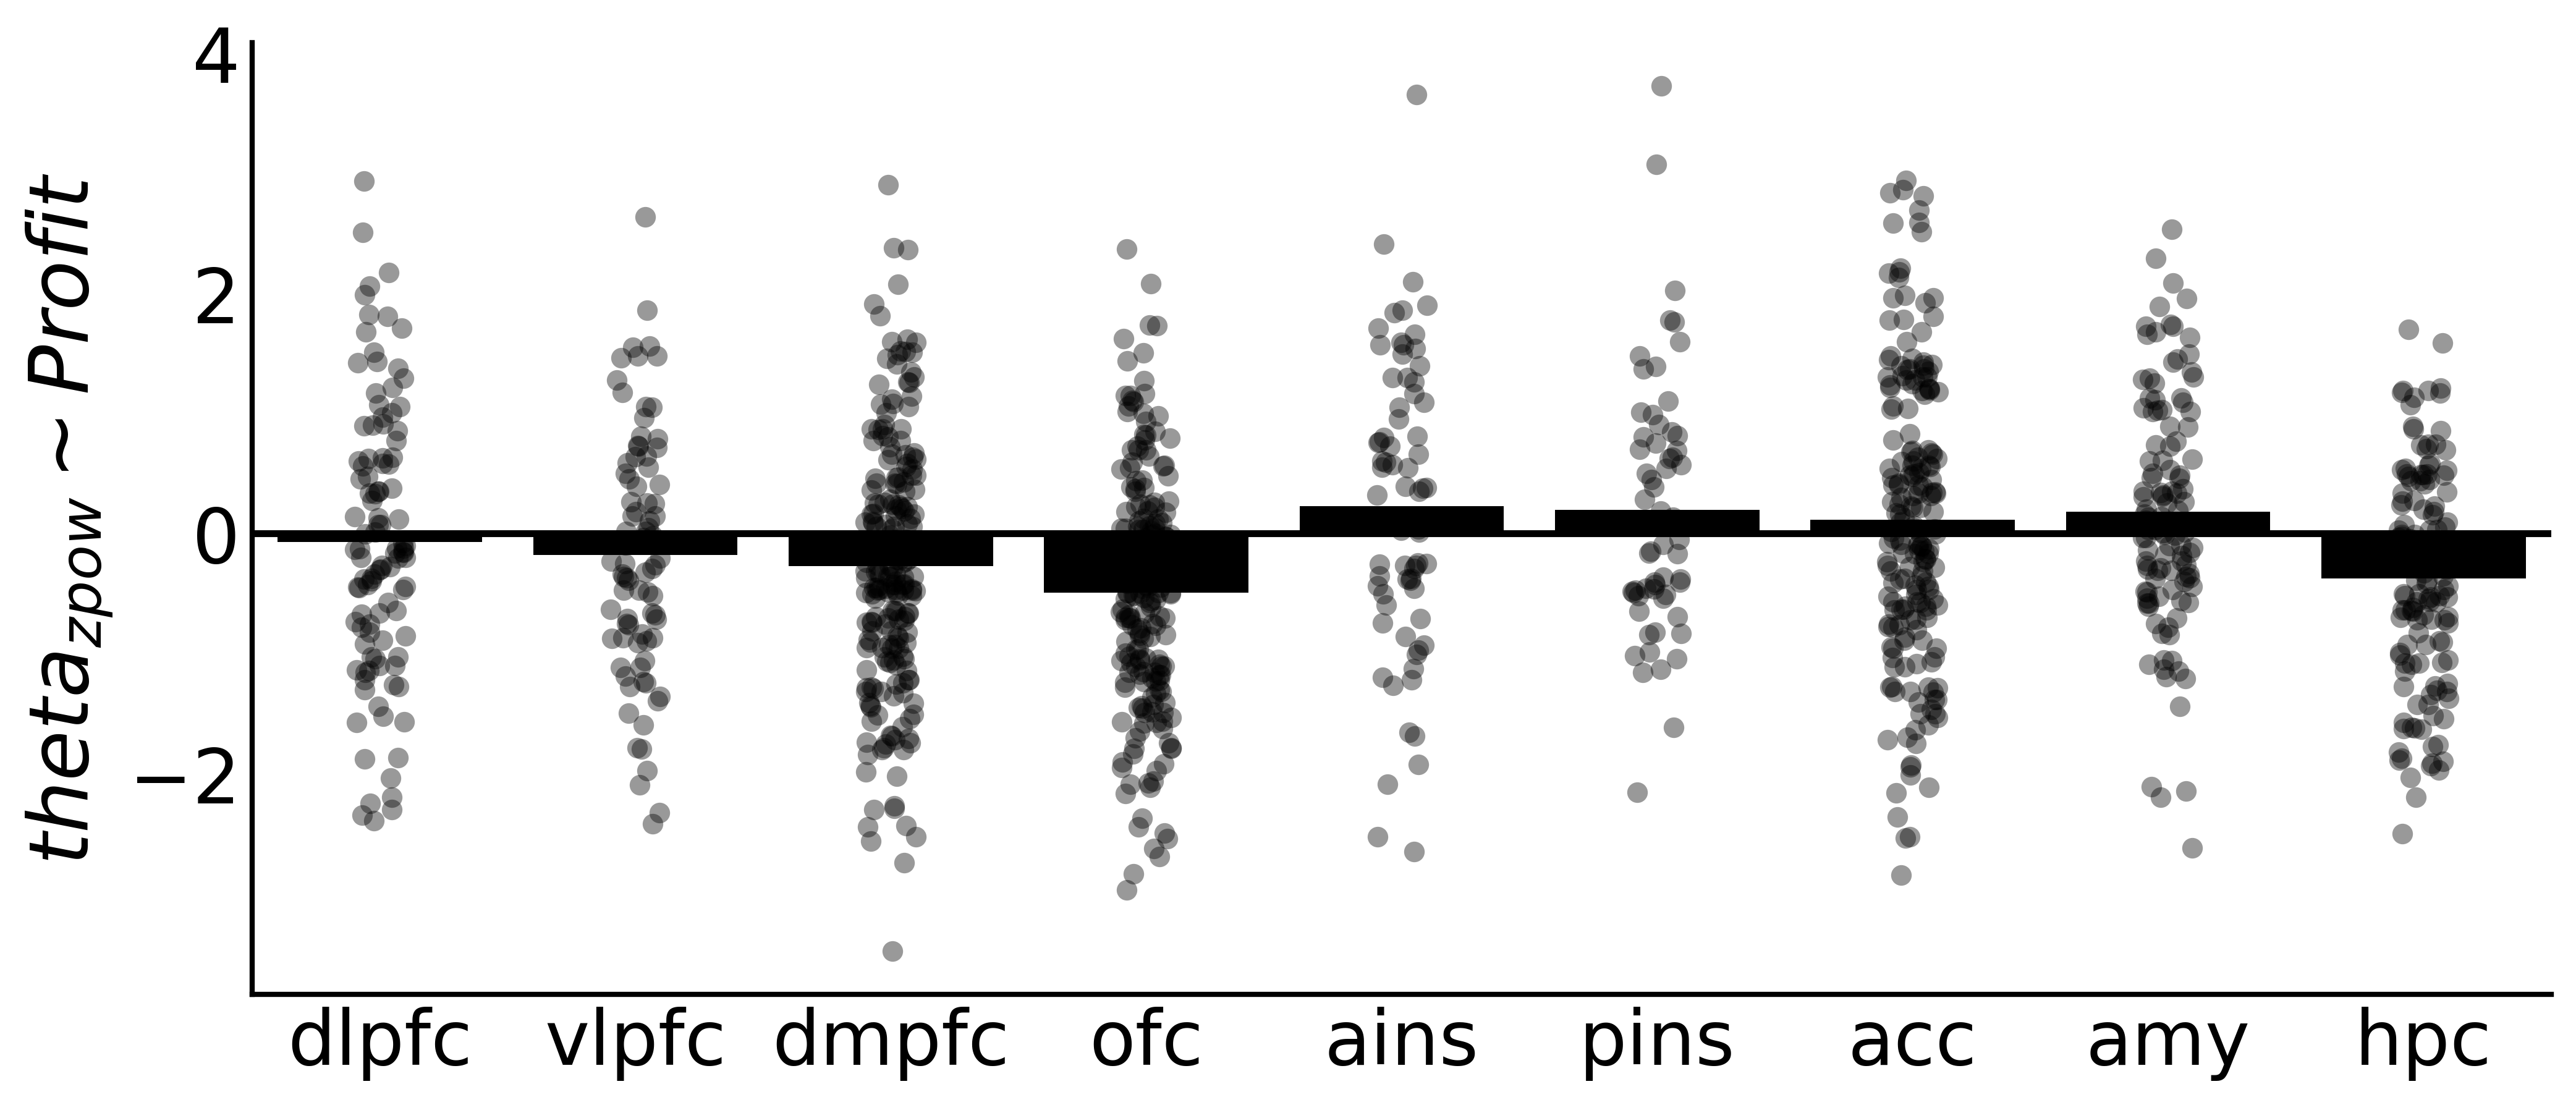

In [45]:
### WITHOUT RPE IN MODEL

ylabel = fr'${band}_{{zpow}} \sim Profit$'


plot_roi_model_results(results,'roi',Profit_var,bar_order=keep_rois,figsize=(12,5),color='k',
                       ylabel=ylabel,save_fig=True,save_dir=fig_save_path,fig_id=fig_id,dpi=400)



## BDI correlations

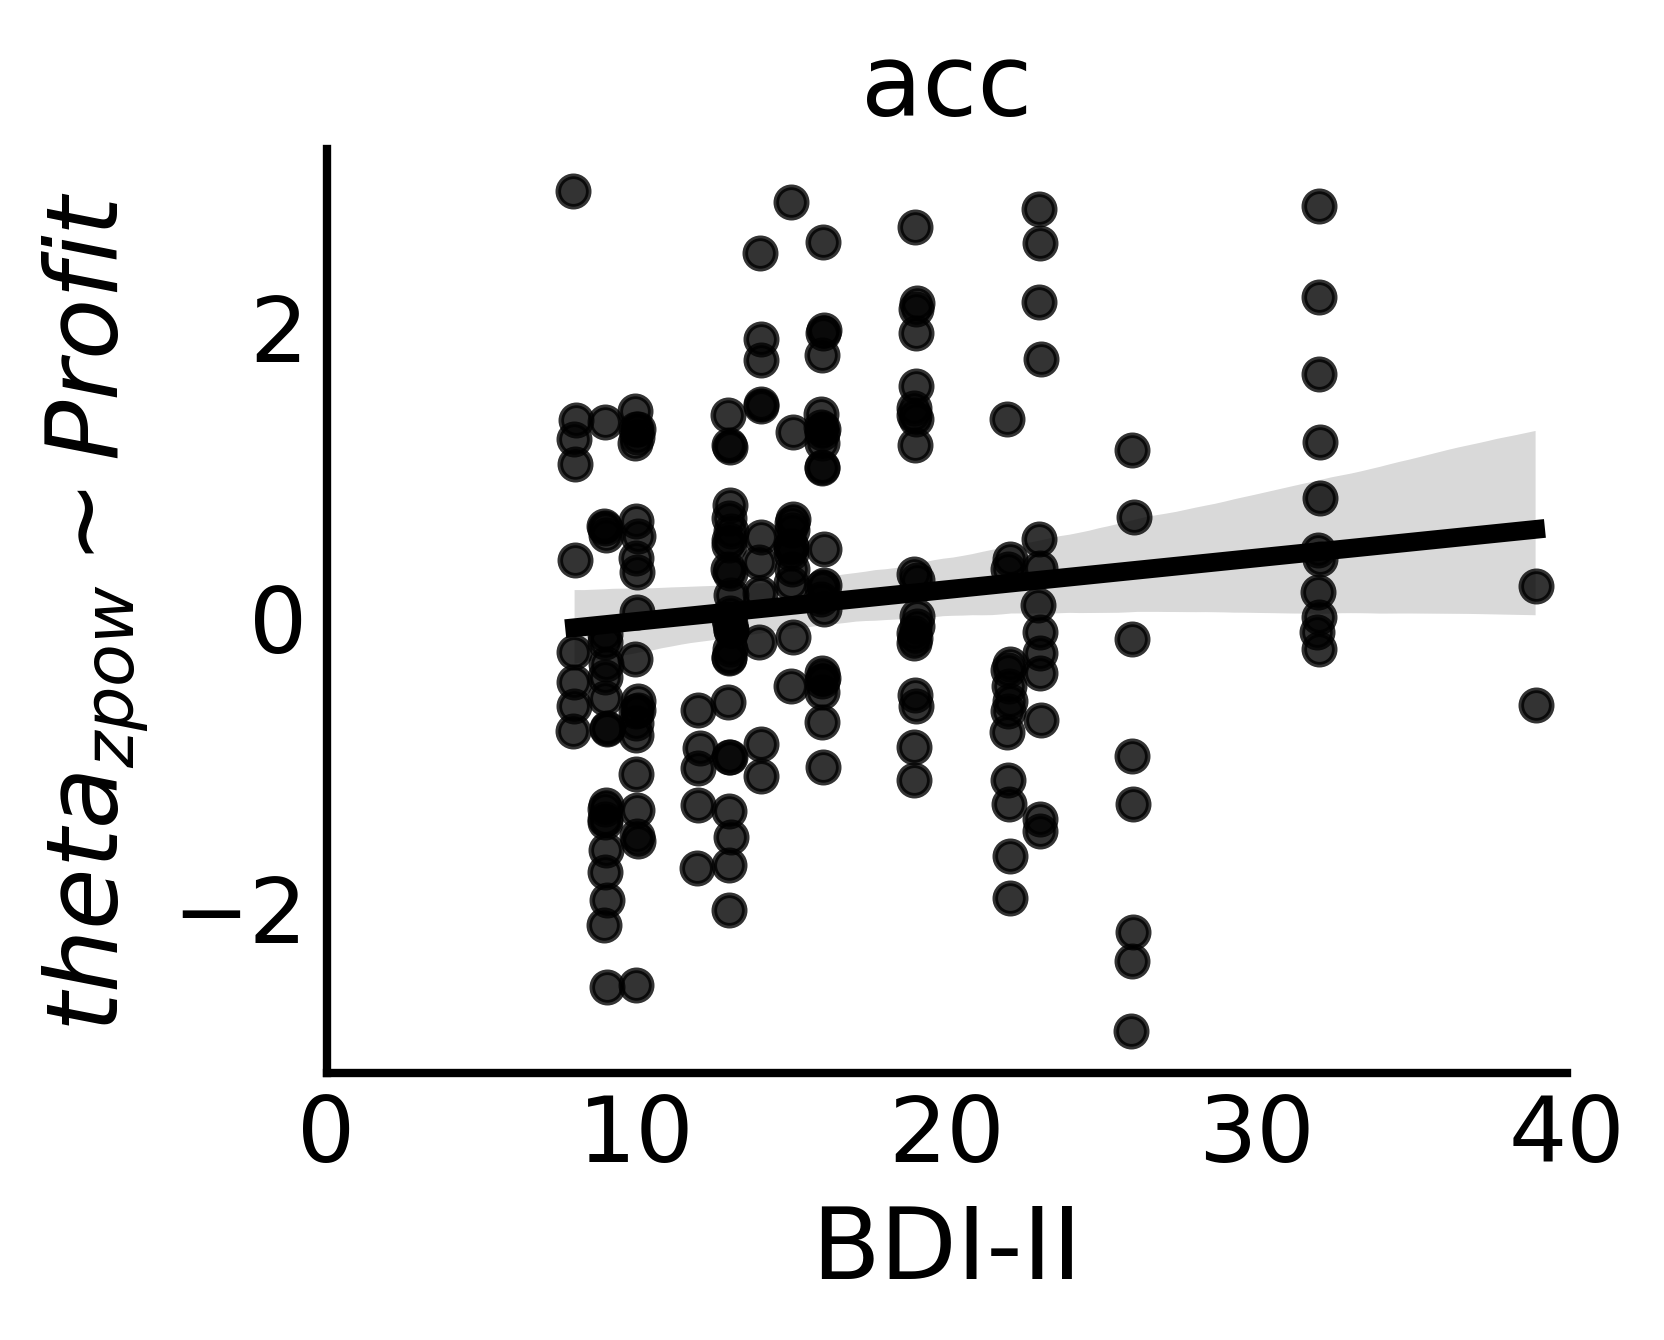

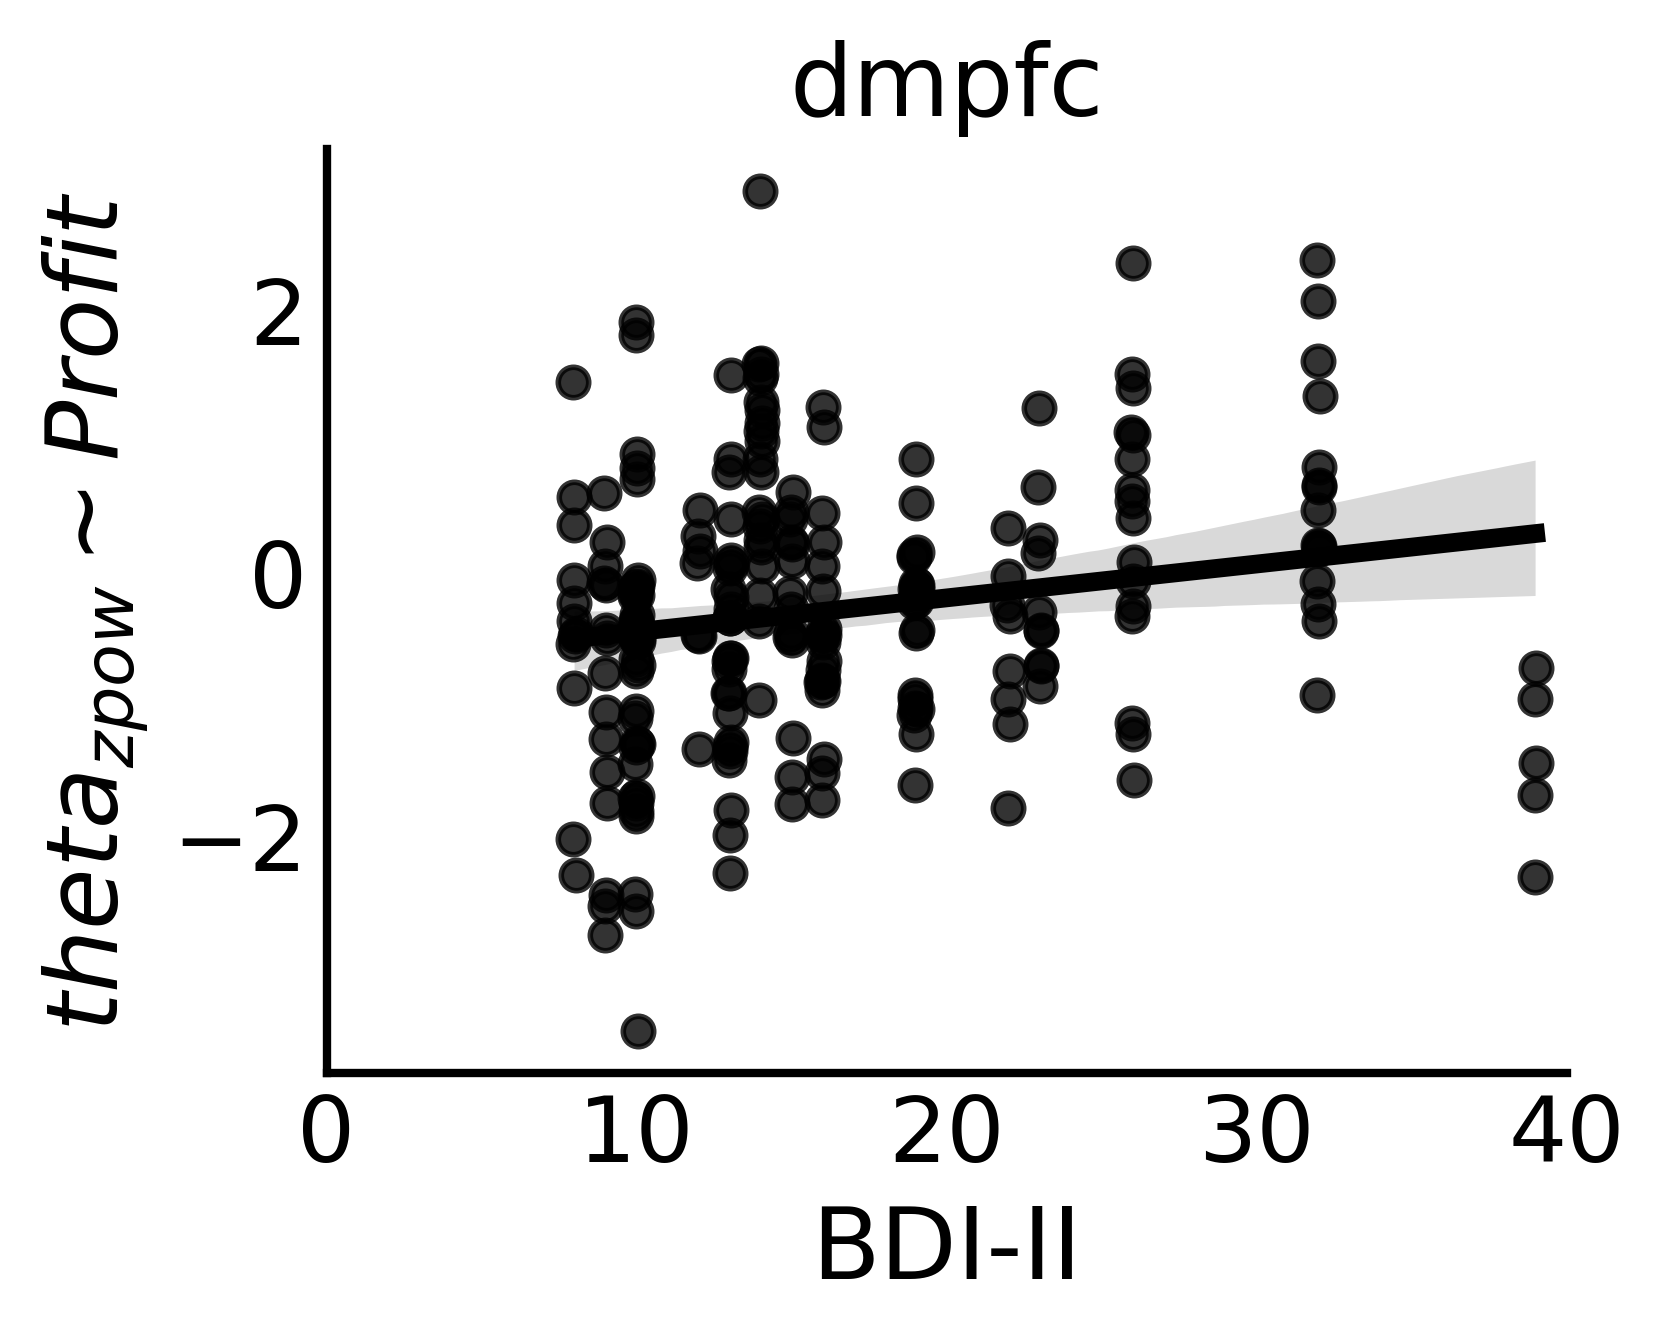

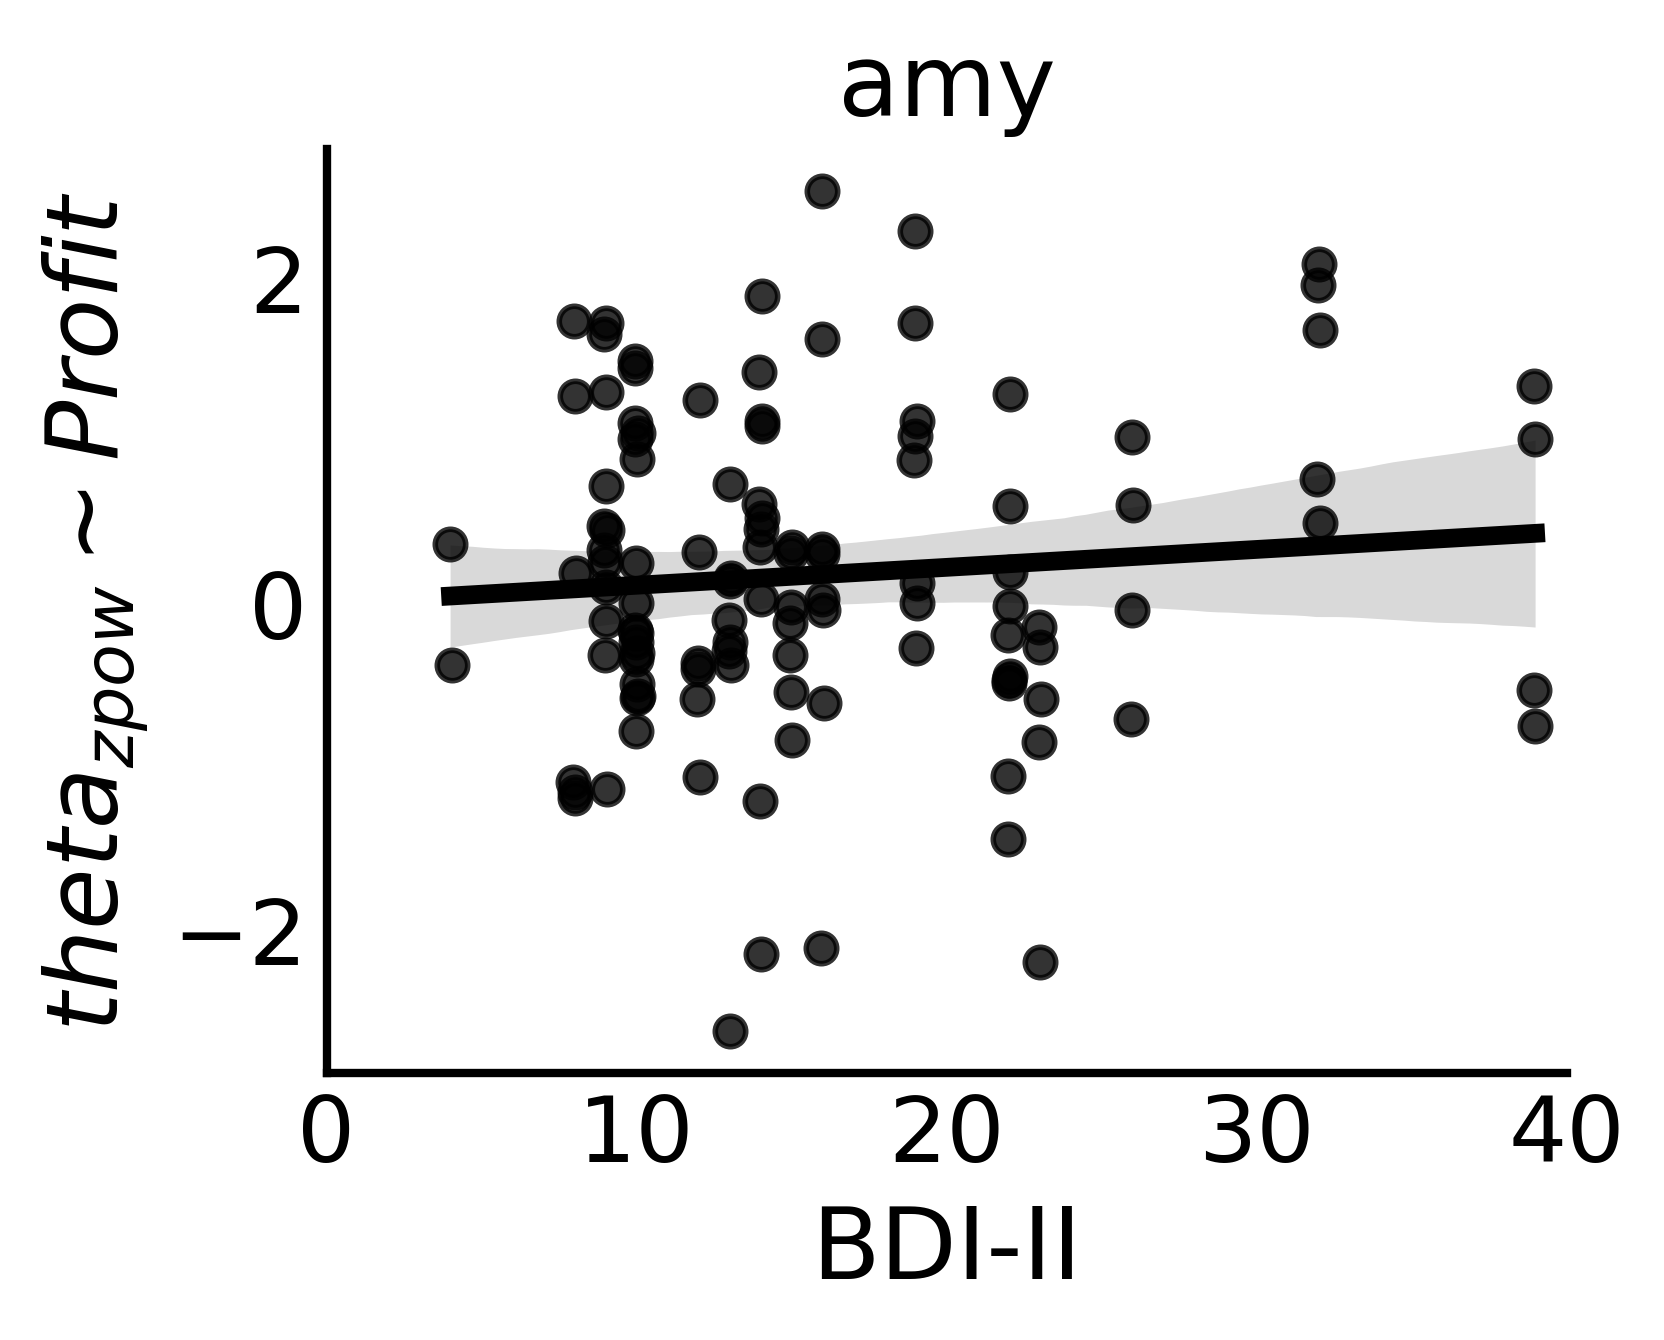

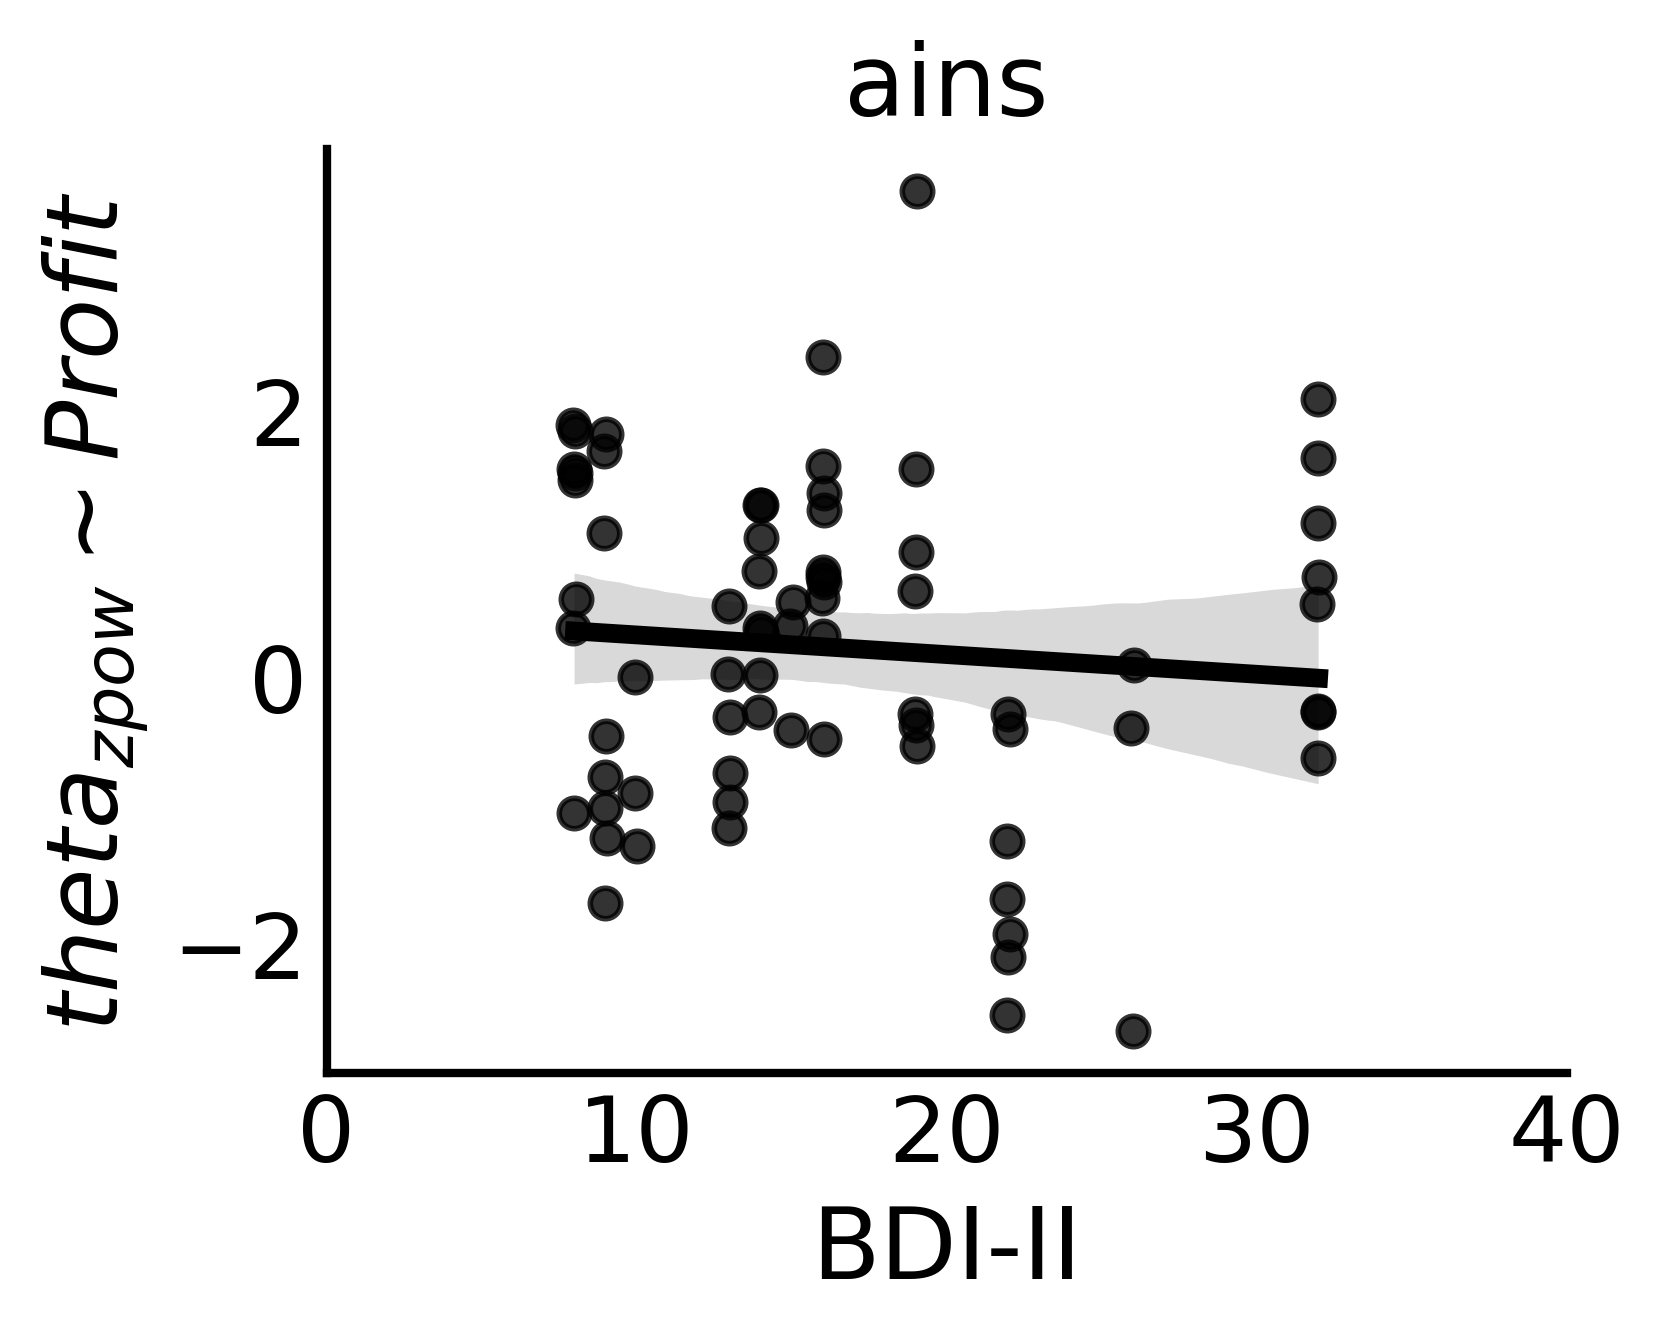

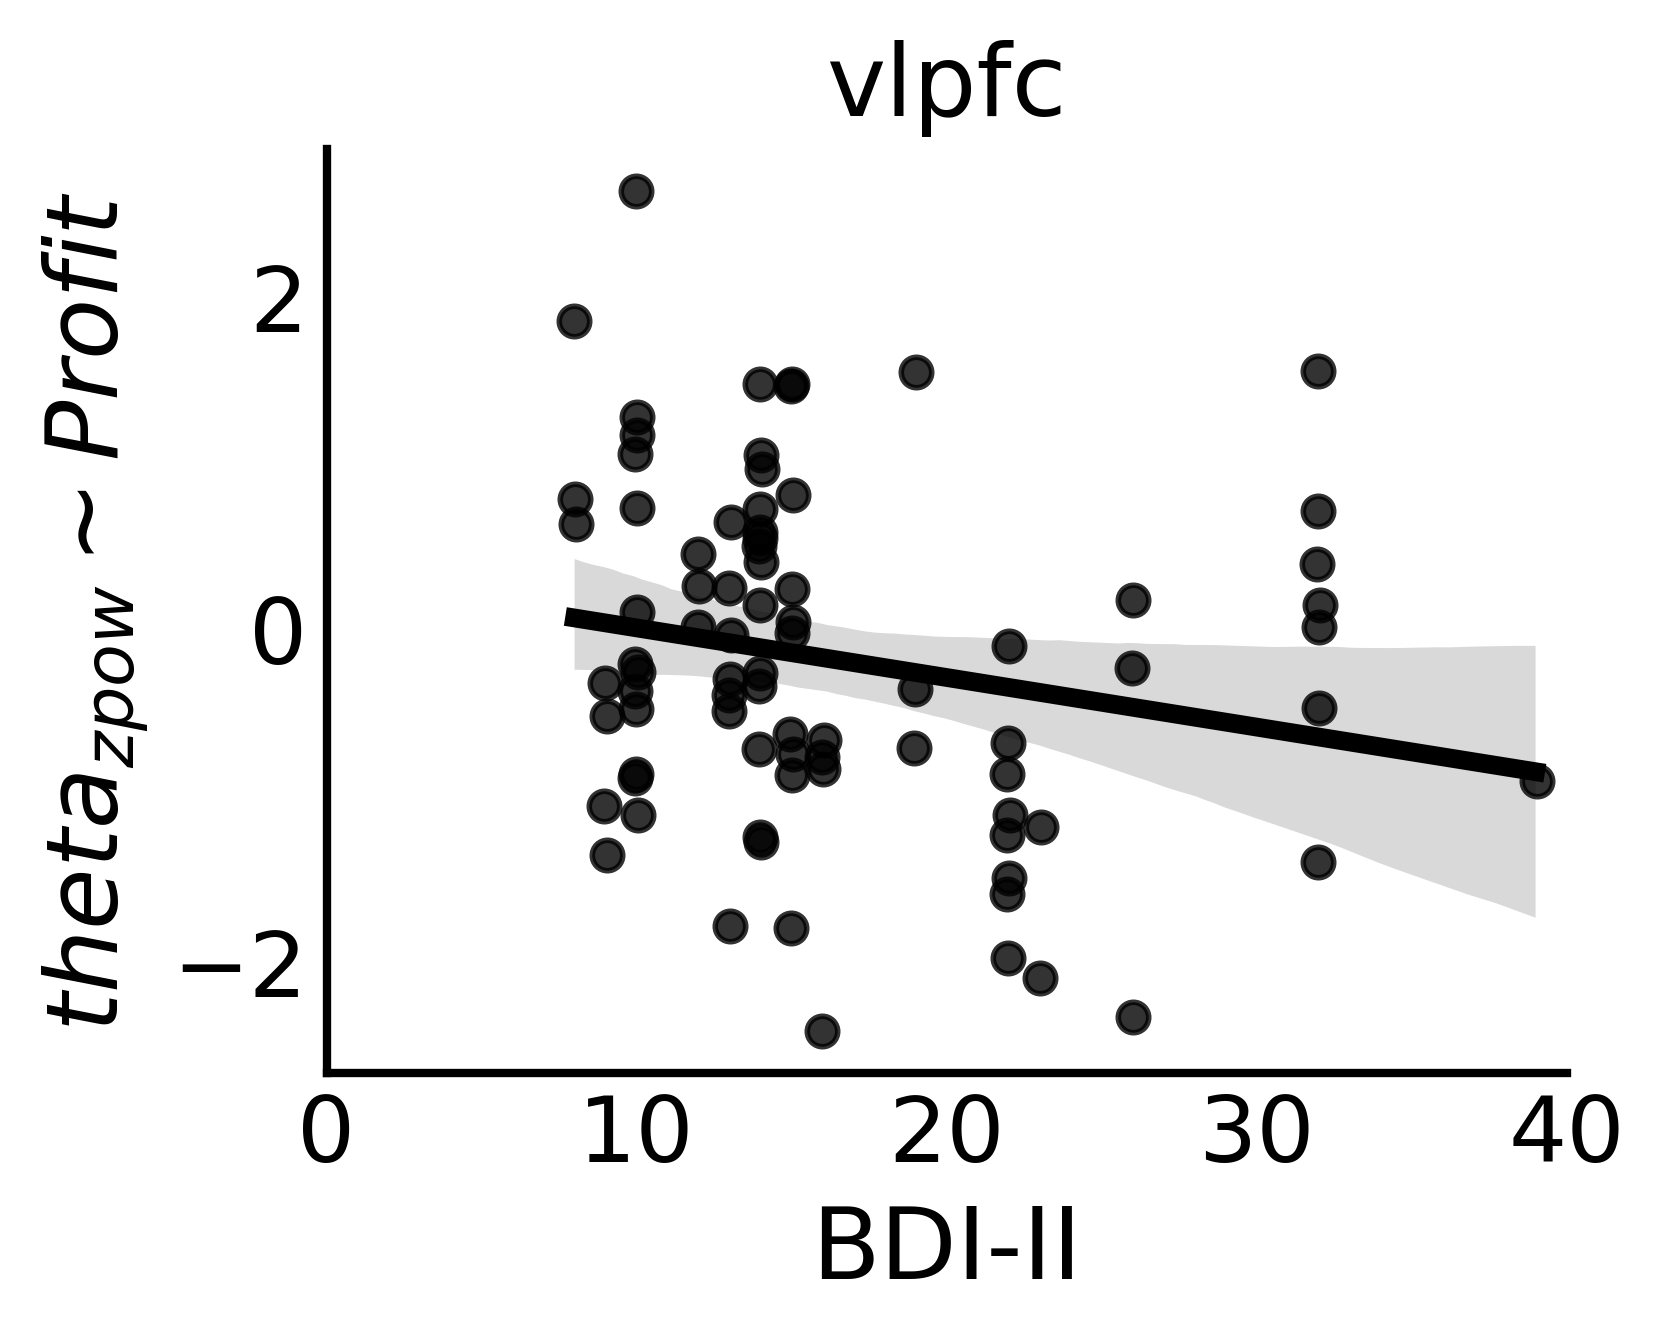

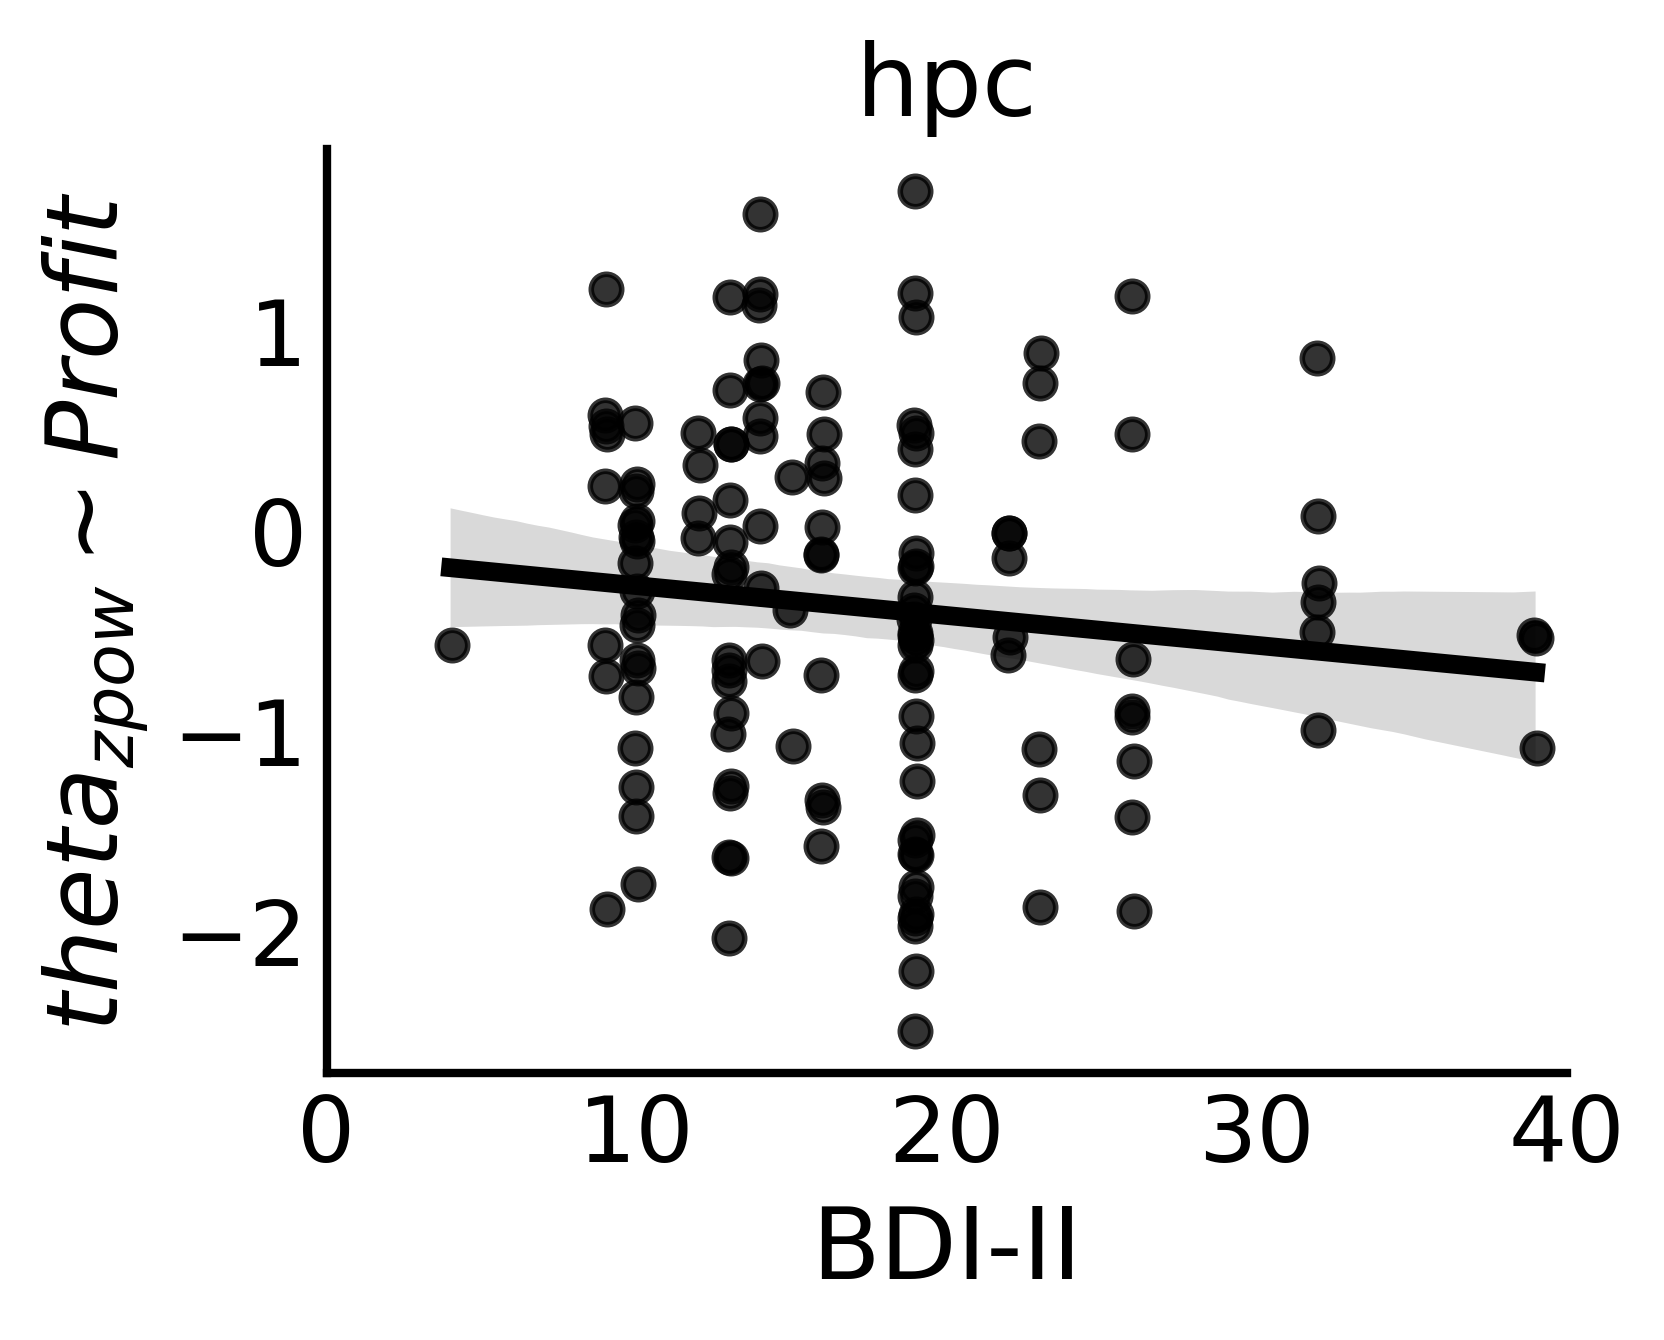

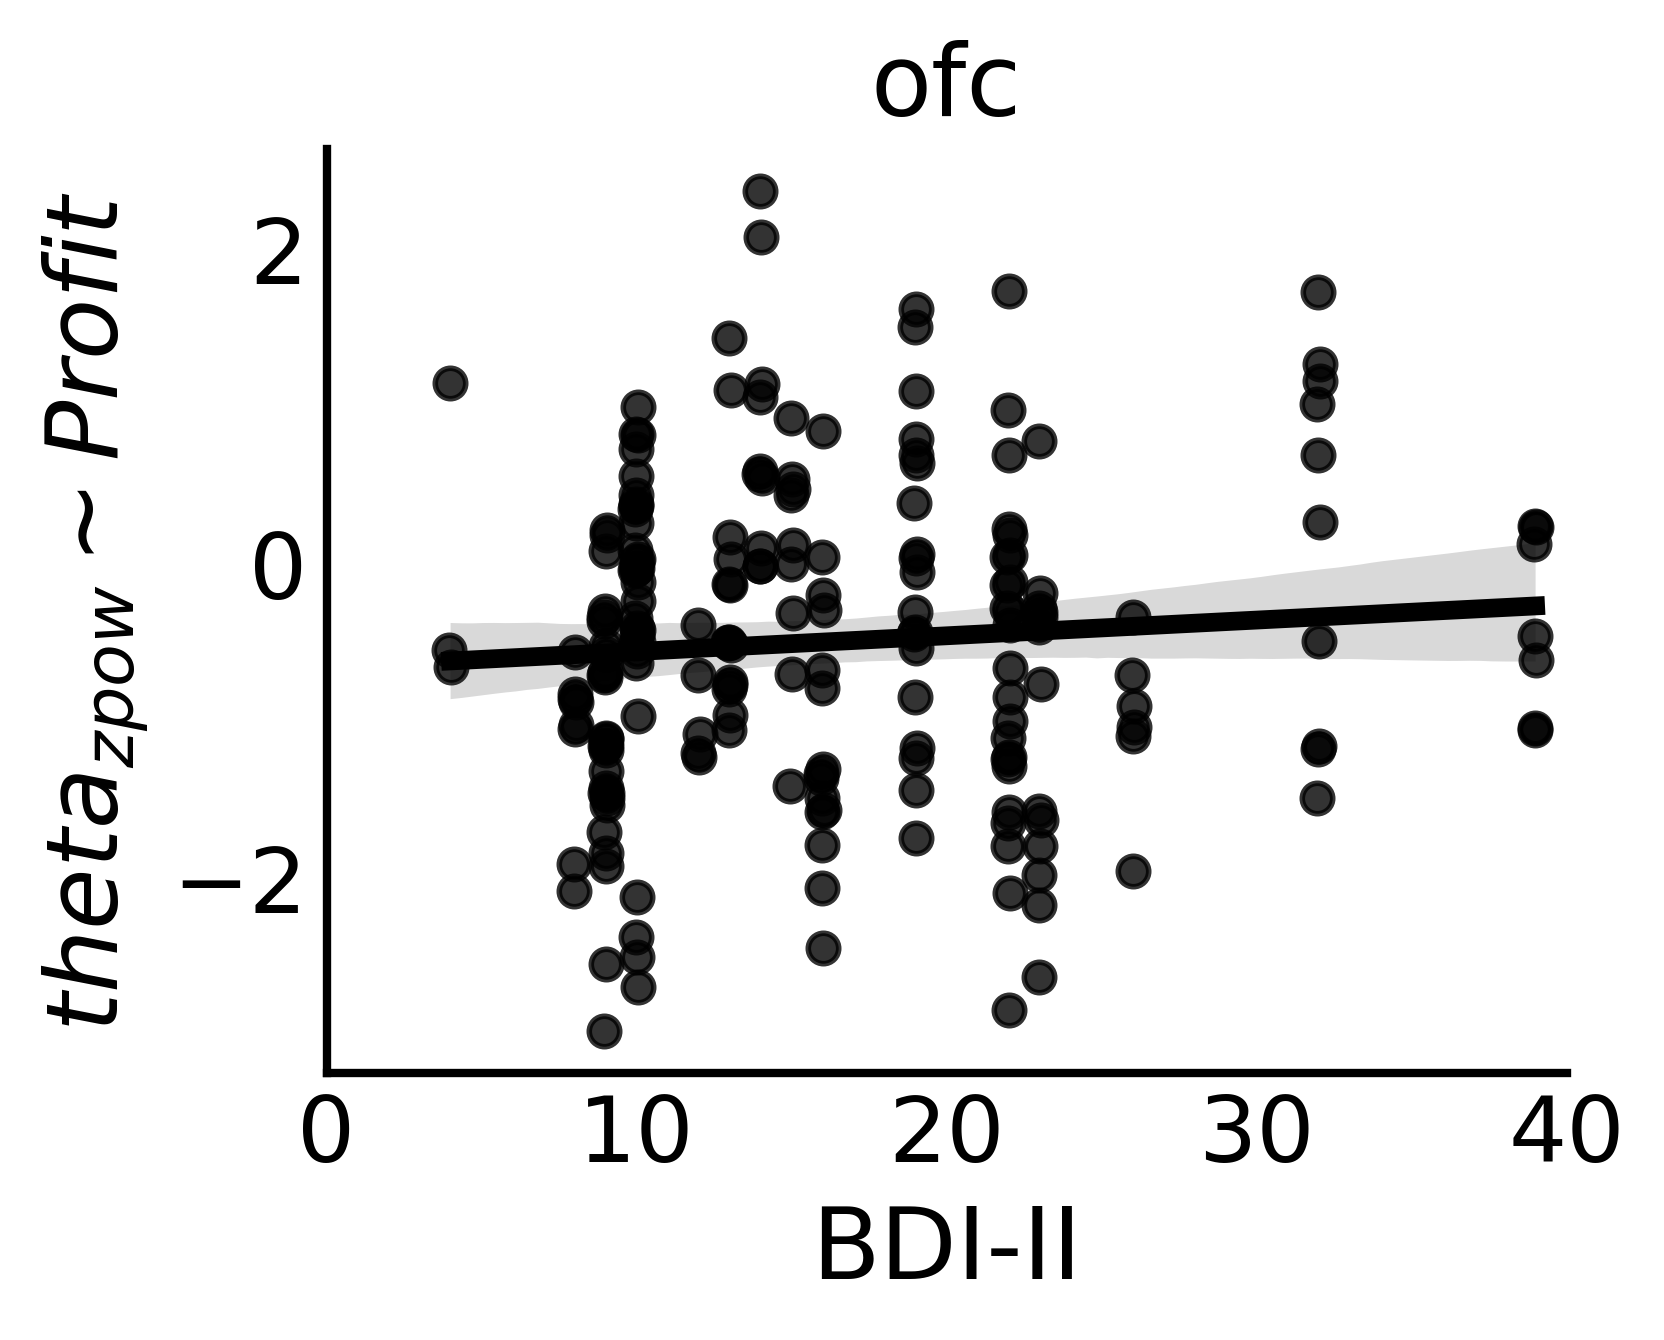

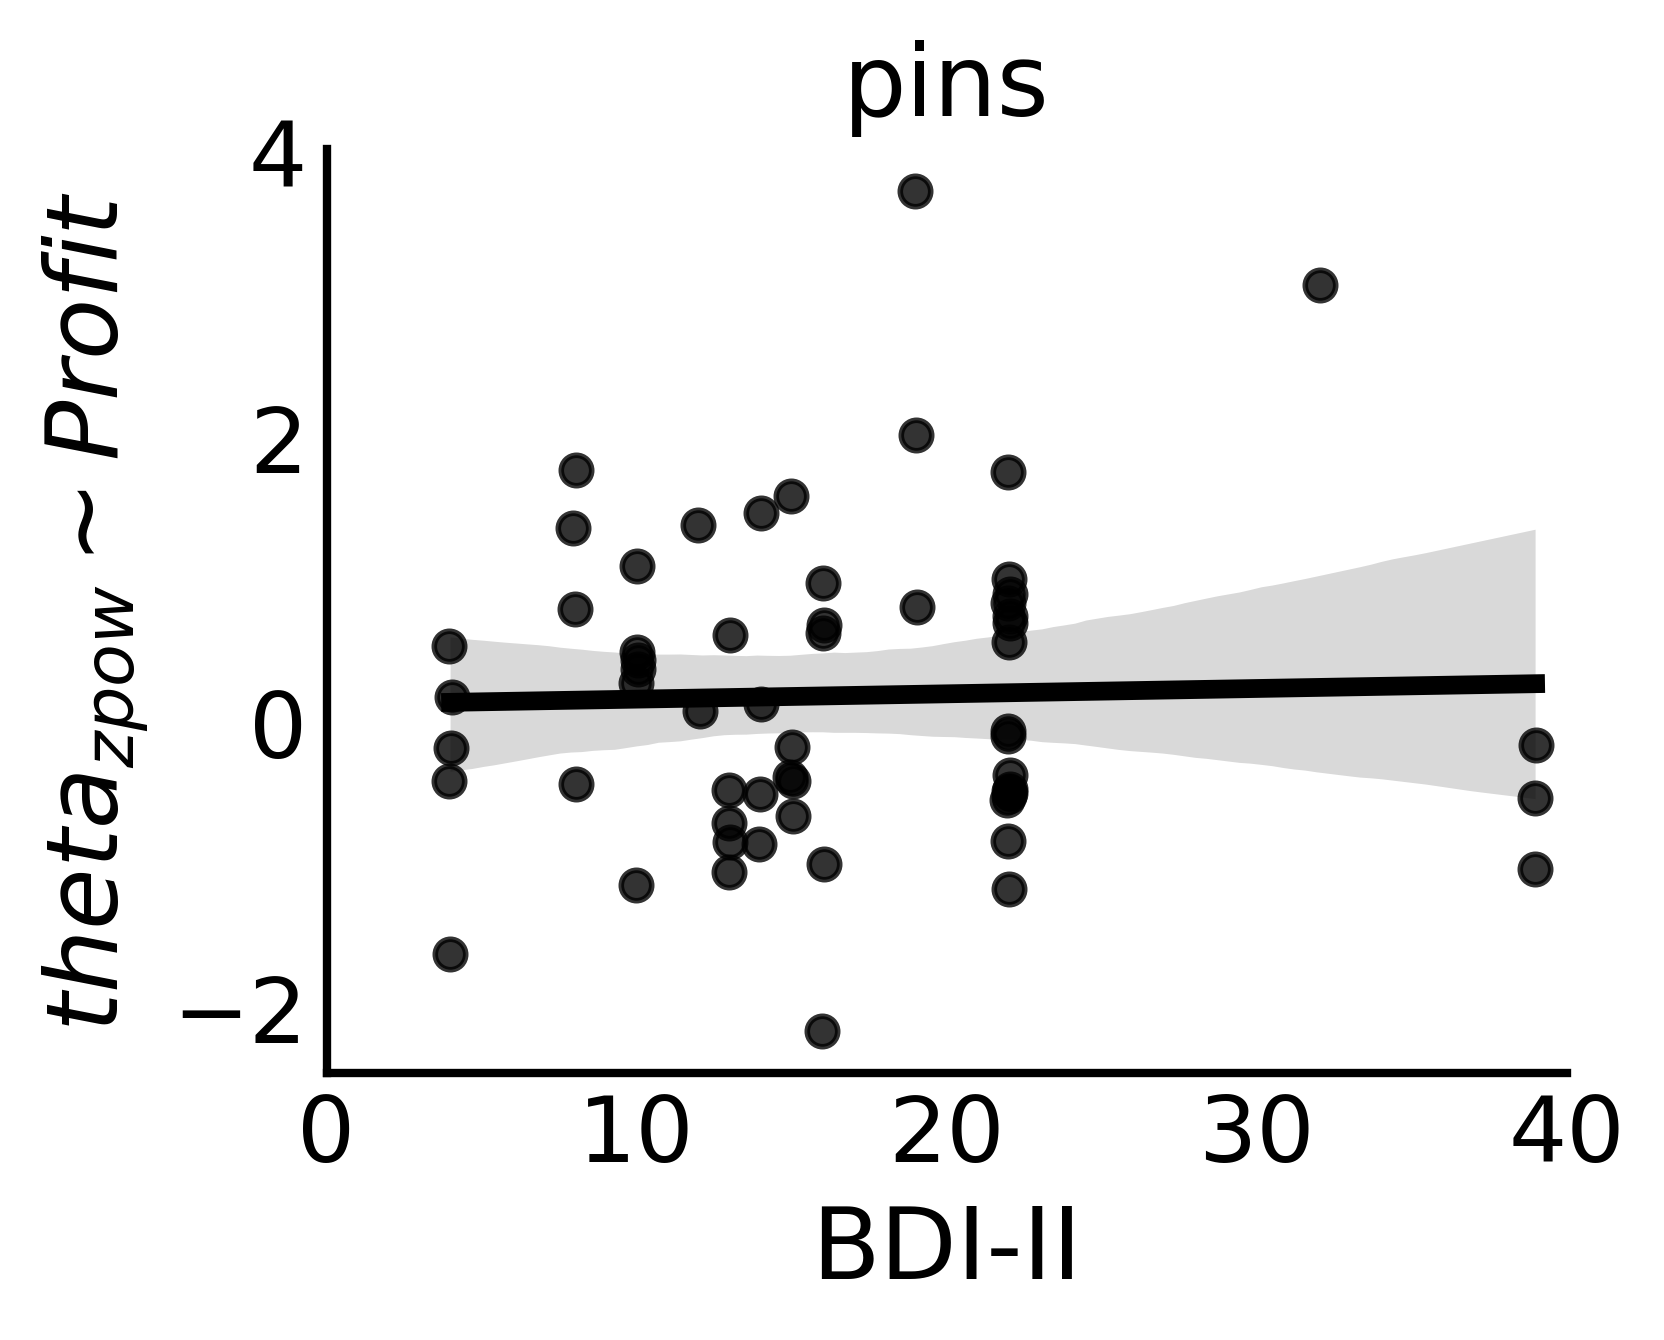

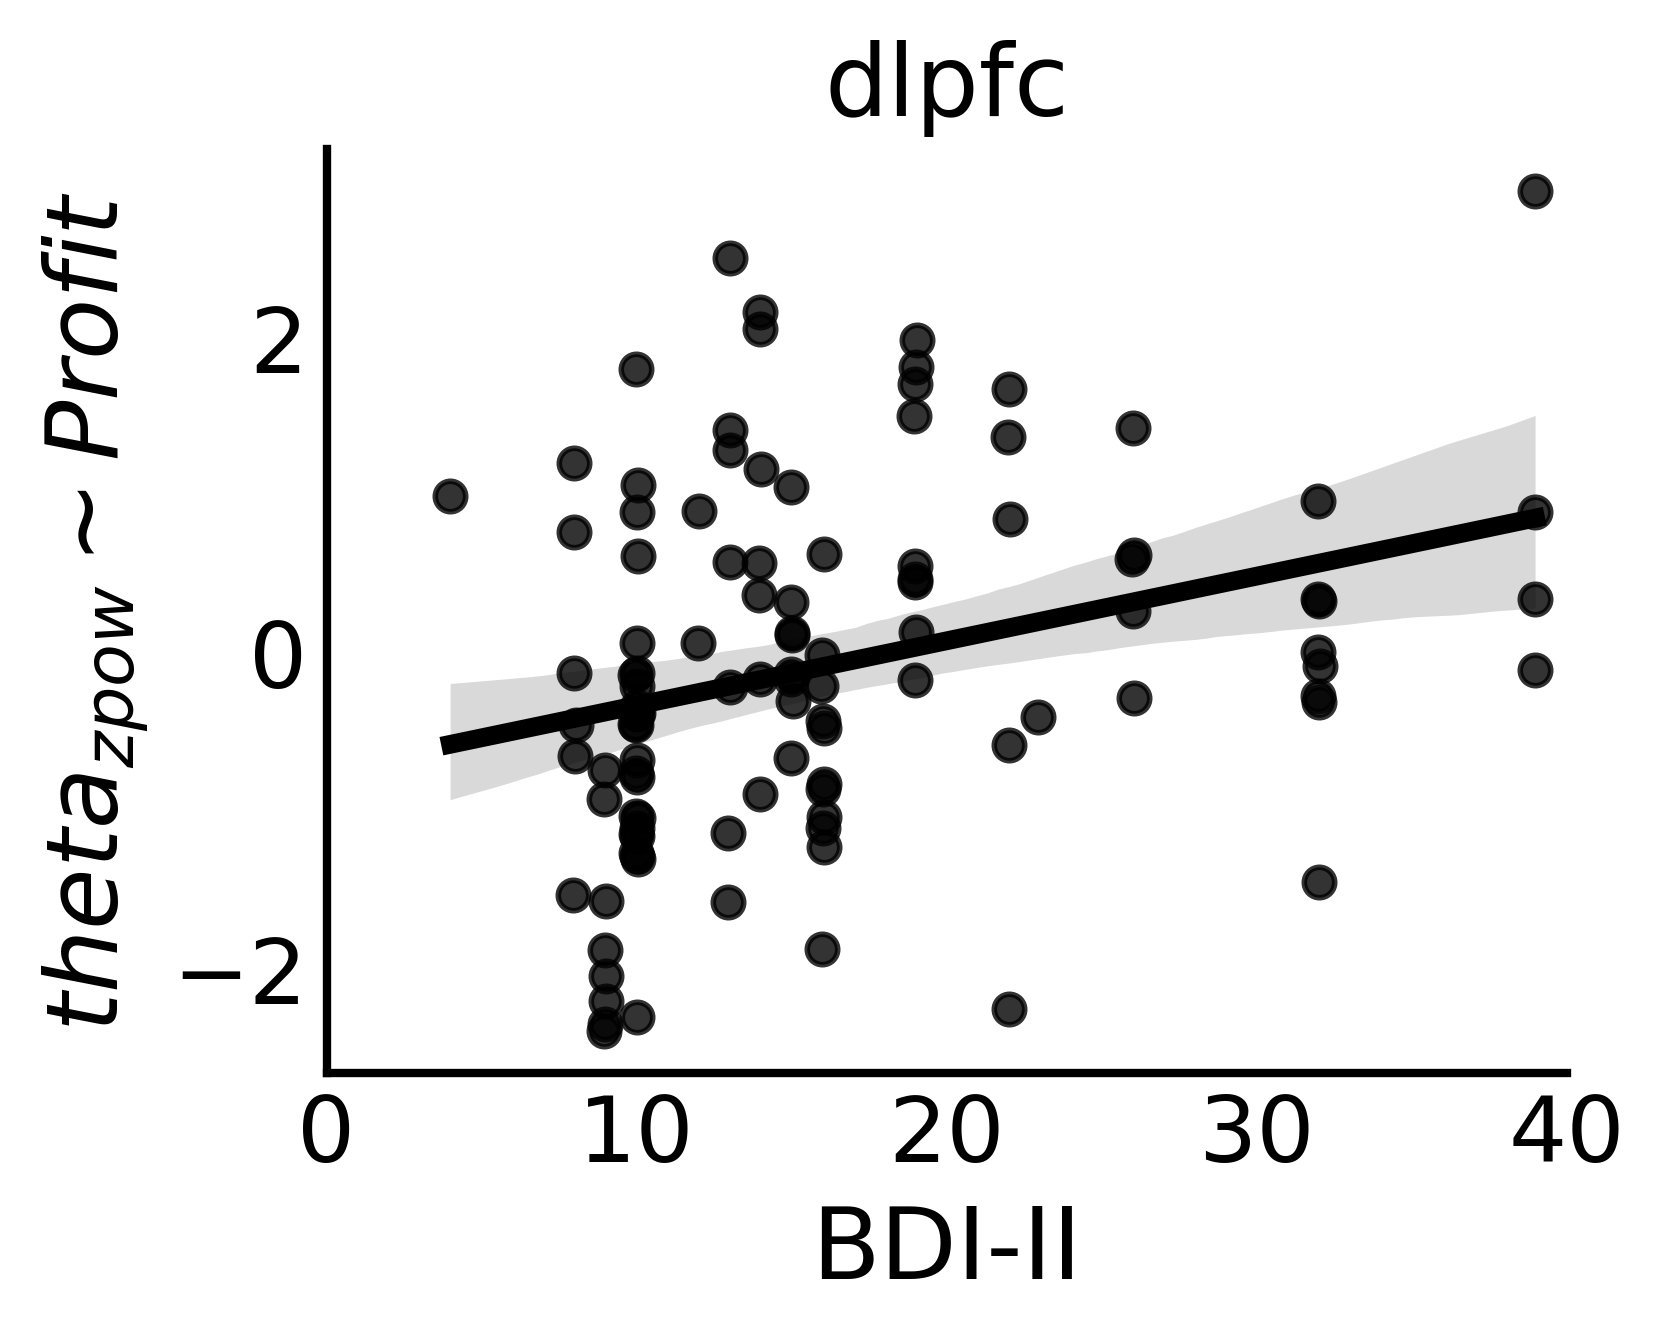

In [46]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in results.roi.unique().tolist():
    
    corr_fig_id = f'{band}_{roi}_bdi_Profitmodel_Profit-coeff_corr_{epoch_len}.pdf'
    
    roi_temp_data = results[results.roi==roi]
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=400)

    sns.regplot(data=roi_temp_data,x='bdi',y='Z_Score_Profit',scatter=True,ci=95,
                fit_reg=True,color = 'k',x_jitter = 0.05,scatter_kws={'s':30}) #034975
    
    plt.xlabel('BDI-II')
    plt.xlim([0,40])
    
    plt.tick_params(length=0) 
    plt.ylabel(fr'${band}_{{zpow}} \sim Profit$')


    plt.title(f'{roi}')
    sns.despine()

    plt.savefig(f'{fig_save_path}{corr_fig_id}', format=corr_fig_id.split('.')[-1], metadata=None,
        bbox_inches='tight', pad_inches=0.1,dpi=400,
        facecolor='auto', edgecolor='auto',
        backend=None)
    


### Test BDI Correlations via robust regression

In [47]:
roi_rlm_dict = {}

for roi in results.roi.unique().tolist():
    roi_df = results[results.roi == roi]
    rlm = sm.RLM(roi_df.bdi.values, sm.add_constant(roi_df.Z_Score_Profit.values), M=sm.robust.norms.HuberT())
    rlm_results = rlm.fit()
    roi_rlm_dict[roi] = rlm_results
    print(roi)
    print(rlm_results.summary())


acc
                    Robust linear Model Regression Results                    
Dep. Variable:                      y   No. Observations:                  193
Model:                            RLM   Df Residuals:                      191
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Tue, 01 Oct 2024                                         
Time:                        11:14:03                                         
No. Iterations:                    14                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.5437      0.434     35.806     